# 1. Data Loading

In [3]:
from google.colab import drive

In [5]:
drive.mount('/content/drive')
DATA_ROOT = '/content/drive/MyDrive/datasets/music_dataset'

Mounted at /content/drive


# 2. EDA

## General EDA

Basic EDA on the Dataset

In [12]:
# setup & locate data
from pathlib import Path
import os

# Point to the folder YOU mounted in Drive
DATA_DIR = Path('/content/drive/MyDrive/datasets/music_dataset')
COMPOSERS = ["Bach","Beethoven","Chopin","Mozart"]

# Handle nested ".../music_dataset/music_dataset" automatically
if all((DATA_DIR / c).is_dir() for c in COMPOSERS):
    DATA_ROOT = DATA_DIR
elif all((DATA_DIR / 'music_dataset' / c).is_dir() for c in COMPOSERS):
    DATA_ROOT = DATA_DIR / 'music_dataset'
else:
    raise RuntimeError("Composer folders not found under DATA_DIR. "
                       "Expected Bach/Beethoven/Chopin/Mozart directly or inside 'music_dataset/'.")

print("DATA_ROOT =", DATA_ROOT)

# Count MIDIs per composer
for c in COMPOSERS:
    comp_dir = DATA_ROOT / c
    n_midis = len([f for f in os.listdir(comp_dir) if f.lower().endswith('.mid')])
    print(f"{c:10s} -> {n_midis} files")


DATA_ROOT = /content/drive/MyDrive/datasets/music_dataset
Bach       -> 131 files
Beethoven  -> 134 files
Chopin     -> 136 files
Mozart     -> 90 files


### Helper Functions

defines safe MIDI loader, note extraction, polyphony, tempo, key estimation, entropy, and small utilities. (No output.)

In [13]:
#  helpers
import numpy as np
import pretty_midi

PC_NAMES = ['C','C#','D','Eb','E','F','F#','G','Ab','A','Bb','B']
KS_MAJOR = np.array([6.35,2.23,3.48,2.33,4.38,4.09,2.52,5.19,2.39,3.66,2.29,2.88], dtype=np.float32); KS_MAJOR/=KS_MAJOR.sum()
KS_MINOR = np.array([6.33,2.68,3.52,5.38,2.60,3.53,2.54,4.75,3.98,2.69,3.34,3.17], dtype=np.float32); KS_MINOR/=KS_MINOR.sum()

def safe_load_pm(path: Path):
    try:
        return pretty_midi.PrettyMIDI(str(path))
    except Exception:
        return None

def piece_end_time(pm):
    ends = [n.end for inst in pm.instruments for n in inst.notes]
    return max(ends) if ends else 0.0

def extract_note_arrays(pm, exclude_drums=True):
    starts, ends, pitch, vel = [], [], [], []
    for inst in pm.instruments:
        if exclude_drums and inst.is_drum:
            continue
        for n in inst.notes:
            starts.append(n.start); ends.append(n.end)
            pitch.append(n.pitch);  vel.append(n.velocity/127.0)
    if not starts:
        return None
    starts = np.asarray(starts, dtype=np.float32)
    ends   = np.asarray(ends,   dtype=np.float32)
    pitch  = np.asarray(pitch,  dtype=np.int32)
    vel    = np.asarray(vel,    dtype=np.float32)
    order = np.argsort(starts)
    return starts[order], ends[order], pitch[order], vel[order]

def compute_polyphony(pm):
    events = []
    for inst in pm.instruments:
        for n in inst.notes:
            events.append((n.start, +1)); events.append((n.end, -1))
    if not events:
        return 0.0
    events.sort()
    active = 0; last_t = events[0][0]; area = 0.0
    for t, d in events:
        if t > last_t:
            area += active * (t - last_t); last_t = t
        active += d
    total_time = max(piece_end_time(pm) - events[0][0], 1e-6)
    return area / total_time

def get_tempo_bpm(pm):
    tempi, times = pm.get_tempo_changes()  # BPM + boundaries (sec)
    if len(tempi) == 0:
        return 120.0
    t_end = piece_end_time(pm)
    seg_starts = list(times); seg_ends = list(times[1:]) + [t_end]
    seg_durs = np.maximum(0.0, np.array(seg_ends) - np.array(seg_starts))
    return float(np.average(tempi, weights=seg_durs)) if seg_durs.sum() > 0 else float(tempi[-1])

def pitch_class_hist(pitches):
    pc = pitches % 12
    hist = np.bincount(pc, minlength=12).astype(np.float32)
    total = hist.sum()
    return hist / (total if total > 0 else 1)

def rotate(v, n):
    return np.roll(v, -n)

def estimate_key_from_pcs(pitches):
    if len(pitches) == 0:
        return ("Unknown","Unknown",0.0)
    pcs = pitch_class_hist(pitches)
    best_score = -1e9
    best = ("Unknown","Unknown",0.0)
    for root in range(12):
        maj = float((pcs * rotate(KS_MAJOR, root)).sum())
        minr= float((pcs * rotate(KS_MINOR, root)).sum())
        if maj >= minr and maj > best_score:
            best = (PC_NAMES[root], "major", maj); best_score = maj
        if minr>  maj and minr> best_score:
            best = (PC_NAMES[root], "minor", minr); best_score = minr
    return best

def entropy(p):
    p = np.asarray(p, dtype=np.float64); p = p[p>0]
    return float(-(p*np.log2(p)).sum()) if p.size else 0.0

def ngrams(seq, n):
    return list(zip(*[seq[i:] for i in range(n)]))


### parse all pieces → EDA dataframe + initial checks

scans each MIDI, extracts note-level arrays, builds a per-piece DataFrame, and prints head/dtypes/nulls/dupes/describe and class counts.

In [14]:
#  parse all pieces → EDA dataframe + initial checks
import pandas as pd

rows = []
skipped = 0

for comp in COMPOSERS:
    comp_dir = DATA_ROOT/comp
    for fname in sorted([f for f in os.listdir(comp_dir) if f.lower().endswith('.mid')]):
        pm = safe_load_pm(comp_dir/fname)
        if pm is None:
            skipped += 1;
            continue
        arrs = extract_note_arrays(pm)
        if arrs is None:
            skipped += 1;
            continue

        starts, ends, pitch, vel = arrs
        dur  = ends - starts
        rest = np.maximum(0.0, starts - np.concatenate(([starts[0]], ends[:-1])))
        interval = np.zeros_like(pitch, dtype=np.int32)
        if len(pitch)>1: interval[1:] = pitch[1:] - pitch[:-1]

        pcs_hist = pitch_class_hist(pitch)
        k_root, k_mode, _ = estimate_key_from_pcs(pitch)
        bpm  = get_tempo_bpm(pm)
        poly = compute_polyphony(pm)
        pcs  = (pitch % 12)

        rows.append(dict(
            composer=comp, file=fname, path=str(comp_dir/fname),
            note_count=int(len(pitch)),
            piece_seconds=float(ends.max() - starts.min()) if len(starts) else 0.0,
            mean_duration=float(np.mean(dur)) if len(dur) else 0.0,
            mean_velocity=float(np.mean(vel)) if len(vel) else 0.0,
            pitch_min=int(np.min(pitch)) if len(pitch) else 0,
            pitch_max=int(np.max(pitch)) if len(pitch) else 0,
            pitch_range=int((np.max(pitch)-np.min(pitch)) if len(pitch) else 0),
            unique_pitches=int(len(np.unique(pitch))) if len(pitch) else 0,
            polyphony=float(poly),
            bpm=float(bpm),
            key=f"{k_root} {k_mode}",
            pcs_hist=pcs_hist, pcs=pcs, dur=dur, vel=vel, rest=rest, interval=interval,
            entropy=float(entropy(pcs_hist))
        ))

eda = pd.DataFrame(rows)
print(f"Parsed pieces: {len(eda)} | Skipped (bad/empty): {skipped}")

print("\n=== HEAD ===")
print(eda.head(10))

print("\n=== DTYPES ===")
print(eda.dtypes)

print("\n=== NULL COUNTS ===")
print(eda.isna().sum())

print("\n=== DUPLICATE (composer,file) ROWS ===")
print(eda.duplicated(subset=['composer','file']).sum())

print("\n=== DESCRIBE (numeric) ===")
num_desc = eda.select_dtypes(include=[np.number]).describe().T
print(num_desc)

print("\n=== PIECES PER COMPOSER ===")
print(eda['composer'].value_counts())


Parsed pieces: 490 | Skipped (bad/empty): 1

=== HEAD ===
  composer                           file  \
0     Bach                   AveMaria.mid   
1     Bach  Bwv0525 Sonate en trio n1.mid   
2     Bach  Bwv0526 Sonate en trio n2.mid   
3     Bach  Bwv0527 Sonate en trio n3.mid   
4     Bach  Bwv0528 Sonate en trio n4.mid   
5     Bach  Bwv0529 Sonate en trio n5.mid   
6     Bach  Bwv0530 Sonate en trio n6.mid   
7     Bach  Bwv0531 Prelude and Fugue.mid   
8     Bach  Bwv0532 Toccata and Fugue.mid   
9     Bach  Bwv0533 Prelude and Fugue.mid   

                                                path  note_count  \
0  /content/drive/MyDrive/datasets/music_dataset/...         793   
1  /content/drive/MyDrive/datasets/music_dataset/...        6077   
2  /content/drive/MyDrive/datasets/music_dataset/...        5379   
3  /content/drive/MyDrive/datasets/music_dataset/...        6056   
4  /content/drive/MyDrive/datasets/music_dataset/...        4221   
5  /content/drive/MyDrive/datasets/mus

Created an EDA dataset. We see there are no duplicate or null values.

### token/file length distributions + per-composer boxplots (colored)

 overall distributions for note_count (token length) and piece_seconds (file length), plus per-composer boxplots to see imbalance.

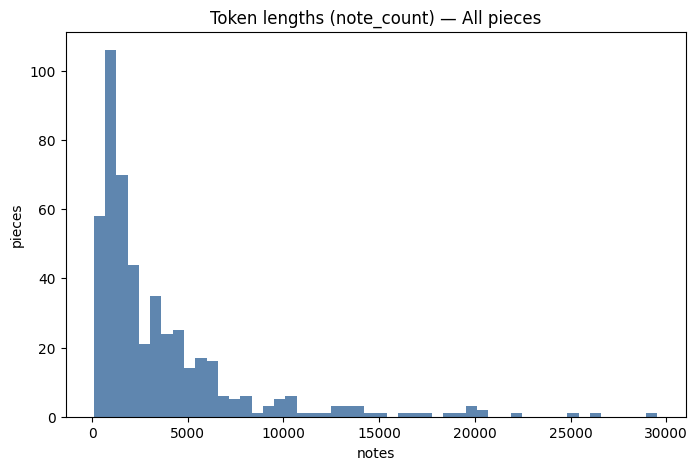

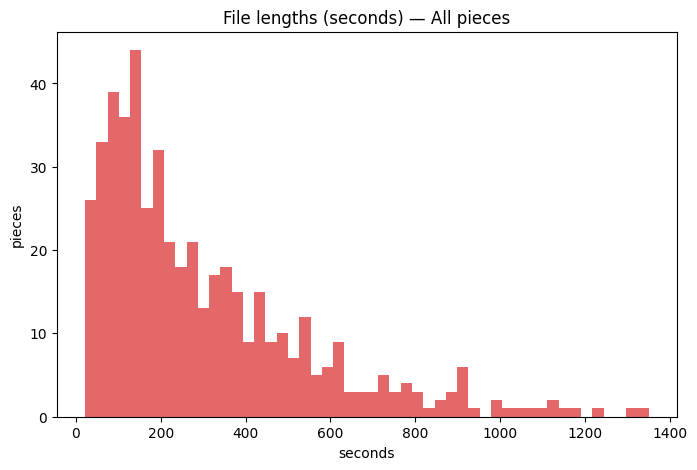

/tmp/ipython-input-3452261124.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax[0].boxplot(data_nc, patch_artist=True, labels=COMPOSERS, showfliers=False)
/tmp/ipython-input-3452261124.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax[1].boxplot(data_ps, patch_artist=True, labels=COMPOSERS, showfliers=False)


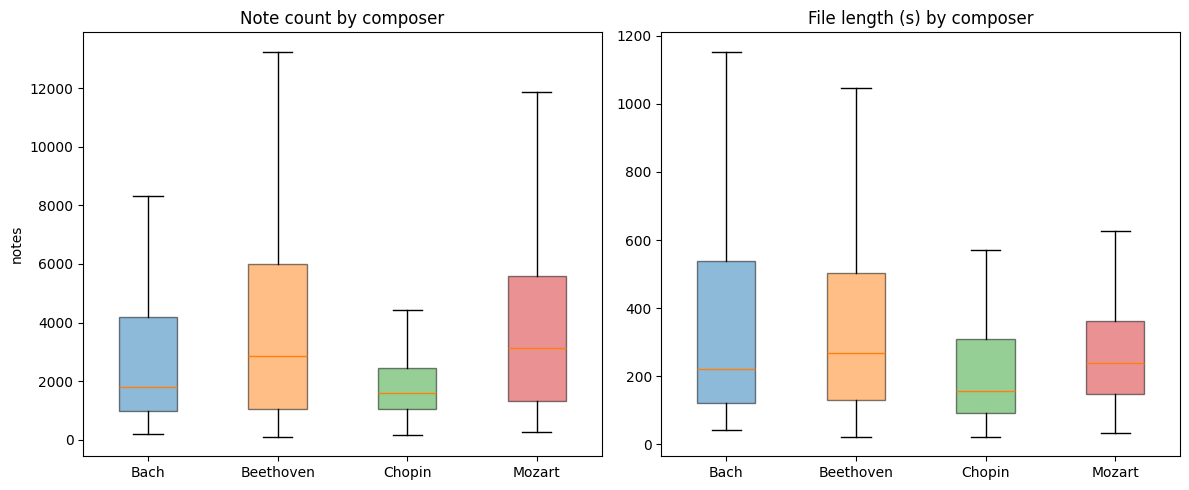

In [15]:
#  token/file length distributions + per-composer boxplots (colored)
import numpy as np
import matplotlib.pyplot as plt

COMPOSERS = ["Bach","Beethoven","Chopin","Mozart"]
COLORS = {'Bach':'#1f77b4','Beethoven':'#ff7f0e','Chopin':'#2ca02c','Mozart':'#d62728'}

#  Note count histogram (all pieces)
plt.figure(figsize=(8,5))
plt.hist(eda['note_count'], bins=50, color='#4e79a7', alpha=0.9)
plt.title("Token lengths (note_count) — All pieces")
plt.xlabel("notes"); plt.ylabel("pieces")
plt.show()

# Piece length histogram (seconds)
plt.figure(figsize=(8,5))
plt.hist(eda['piece_seconds'], bins=50, color='#e15759', alpha=0.9)
plt.title("File lengths (seconds) — All pieces")
plt.xlabel("seconds"); plt.ylabel("pieces")
plt.show()

#  Boxplots by composer: note_count and piece_seconds
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# note_count
data_nc = [eda.loc[eda['composer']==c,'note_count'] for c in COMPOSERS]
bp1 = ax[0].boxplot(data_nc, patch_artist=True, labels=COMPOSERS, showfliers=False)
for patch, c in zip(bp1['boxes'], COMPOSERS):
    patch.set_facecolor(COLORS[c]); patch.set_alpha(0.5)
ax[0].set_title("Note count by composer"); ax[0].set_ylabel("notes")

# piece_seconds
data_ps = [eda.loc[eda['composer']==c,'piece_seconds'] for c in COMPOSERS]
bp2 = ax[1].boxplot(data_ps, patch_artist=True, labels=COMPOSERS, showfliers=False)
for patch, c in zip(bp2['boxes'], COMPOSERS):
    patch.set_facecolor(COLORS[c]); patch.set_alpha(0.5)
ax[1].set_title("File length (s) by composer")

plt.tight_layout(); plt.show()


**Token lengths are super long-tailed** (median ≈ 2k notes; some ~30k). If we don’t control window sampling, a few giant works will dominate training.

File lengths also long-tailed.

**By-composer:** Beethoven/Mozart tend to have more notes and longer spans than Chopin. Length alone could leak the label if we’re not careful.

**Analysis:**

Use sliding note windows like WINDOW=256, STRIDE=128.

Cap windows per piece (e.g., max_windows_per_piece=200) and balance per composer so long pieces don’t overwhelm.

Later we’ll add class weights (Mozart has fewer pieces) and a robust tempo metric (BPM metadata has outliers).



# 3. LSTM

## 3.1 LSTM EDA

### 3.1.1 Mean note duration per piece (bar)

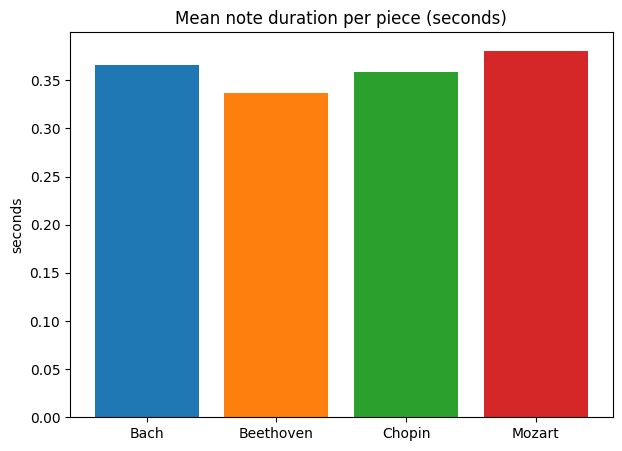

In [16]:
# mean note duration per piece by composer (bar, colored)
import numpy as np
import matplotlib.pyplot as plt

COMPOSERS = ["Bach","Beethoven","Chopin","Mozart"]
COLORS = {'Bach':'#1f77b4','Beethoven':'#ff7f0e','Chopin':'#2ca02c','Mozart':'#d62728'}

mean_dur_vals = [eda.loc[eda['composer']==c, 'mean_duration'].mean() for c in COMPOSERS]
plt.figure(figsize=(7,5))
plt.bar(COMPOSERS, mean_dur_vals, color=[COLORS[c] for c in COMPOSERS])
plt.title("Mean note duration per piece (seconds)")
plt.ylabel("seconds")
plt.show()


pretty close across composers; Mozart a bit longer on average, Beethoven a bit shorter. Not a huge separator, but worth keeping as a weak cue.

### 3.1.2 Pitch Class Profile

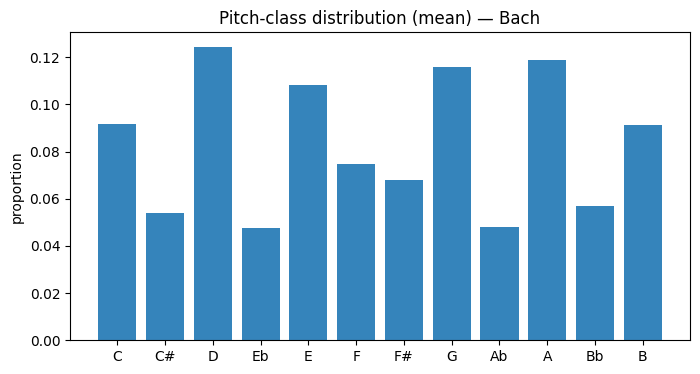

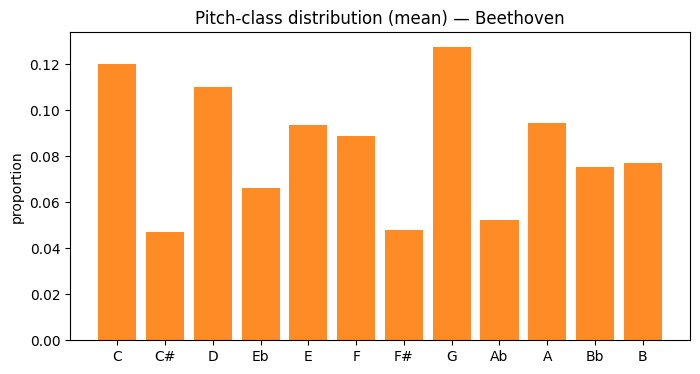

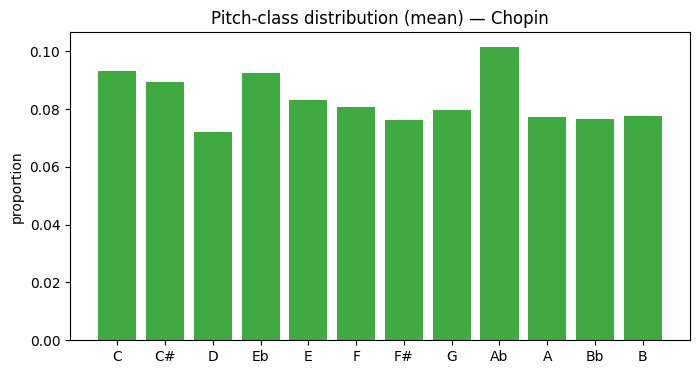

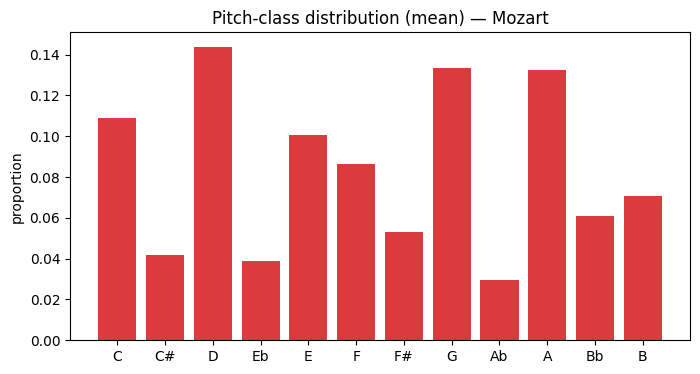

In [17]:
#  pitch-class distributions by composer (colored)
import numpy as np
import matplotlib.pyplot as plt

PC_NAMES = ['C','C#','D','Eb','E','F','F#','G','Ab','A','Bb','B']
COMPOSERS = ["Bach","Beethoven","Chopin","Mozart"]
COLORS = {'Bach':'#1f77b4','Beethoven':'#ff7f0e','Chopin':'#2ca02c','Mozart':'#d62728'}

for c in COMPOSERS:
    rows = eda.loc[eda['composer']==c, 'pcs_hist'].tolist()
    if not rows:
        continue
    pcs_mean = np.mean(np.vstack(rows), axis=0)
    plt.figure(figsize=(8,4))
    plt.bar(range(12), pcs_mean, color=COLORS[c], alpha=0.9)
    plt.xticks(range(12), PC_NAMES)
    plt.ylabel("proportion")
    plt.title(f"Pitch-class distribution (mean) — {c}")
    plt.show()


**Pitch-class profiles:**

* Bach/Beethoven/Mozart show stronger tonal peaks (D, G, A etc.).

* Chopin is flatter (more chromatic), which fits late tonal language.

**This suggests transposition invariance might help:** If we normalize pieces to their estimated key (rotate PCs to C), we remove key bias and emphasize relative harmony.



### 3.1.3 Interval semitone distributions

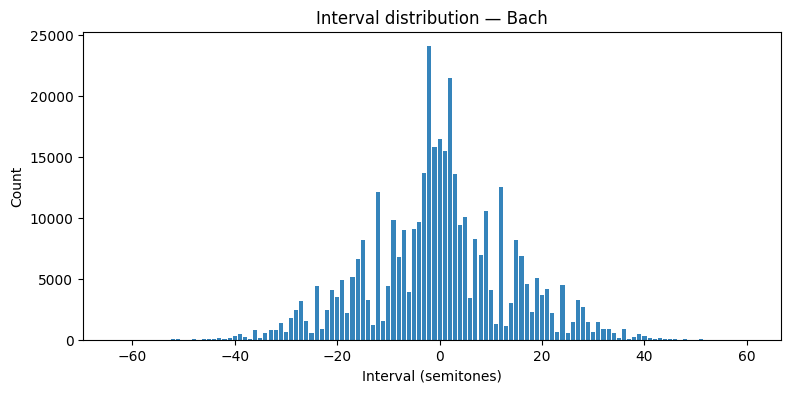

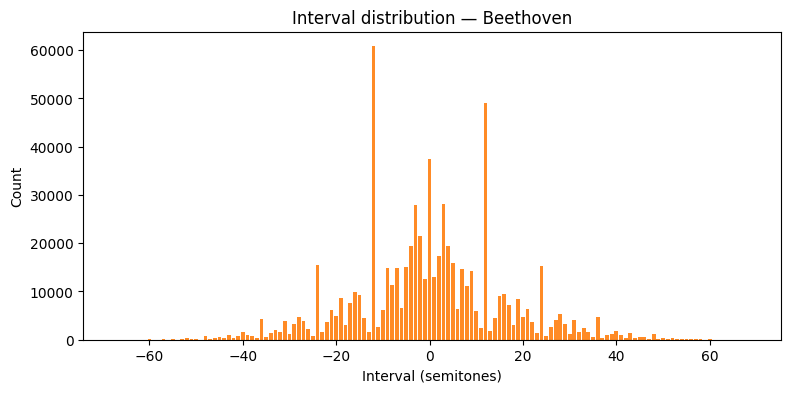

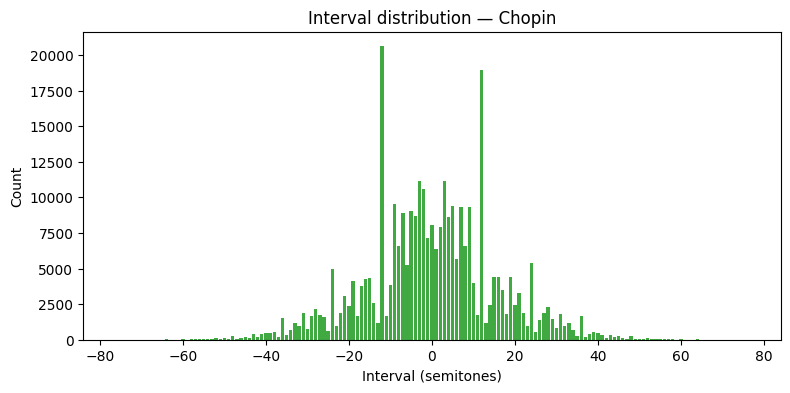

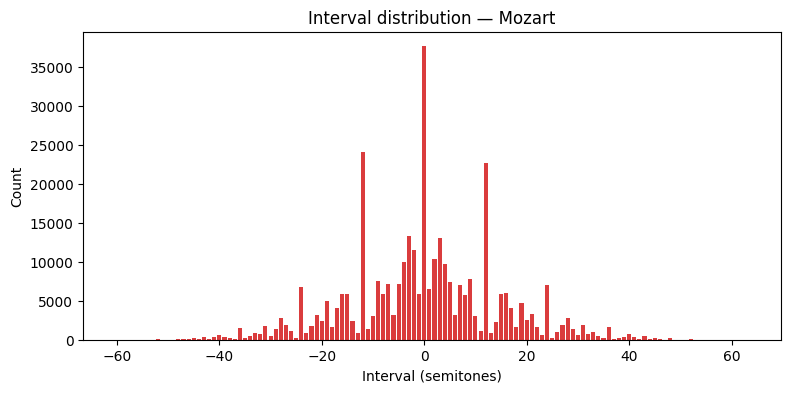

In [18]:
#  interval semitone distributions by composer (colored)
import numpy as np
import matplotlib.pyplot as plt

COMPOSERS = ["Bach","Beethoven","Chopin","Mozart"]
COLORS = {'Bach':'#1f77b4','Beethoven':'#ff7f0e','Chopin':'#2ca02c','Mozart':'#d62728'}

for c in COMPOSERS:
    ints_lists = eda.loc[eda['composer']==c, 'interval'].tolist()
    ints = np.concatenate(ints_lists) if ints_lists else np.array([])
    if ints.size == 0:
        continue
    vals, cnts = np.unique(ints, return_counts=True)
    plt.figure(figsize=(9,4))
    plt.bar(vals, cnts, color=COLORS[c], alpha=0.9)
    plt.xlabel("Interval (semitones)")
    plt.ylabel("Count")
    plt.title(f"Interval distribution — {c}")
    plt.show()


**Interval distributions**: all centered on 0 with strong spikes at ±12 (octaves). Beethoven/Mozart show more pronounced large leaps; Chopin looks a bit tighter. Intervals are definitely informative → we should feed them.

### 3.1.4 velocity distributions by composer

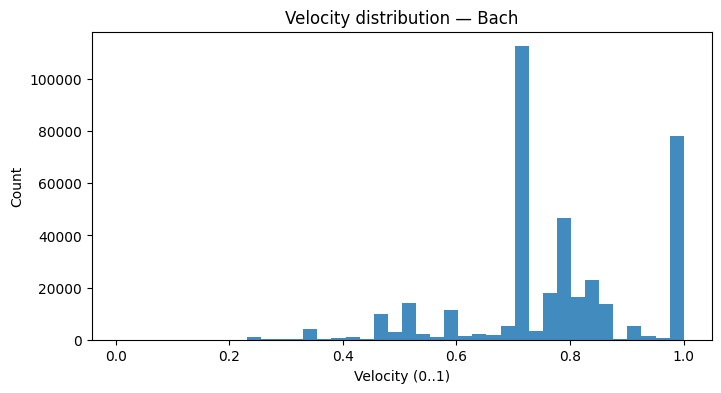

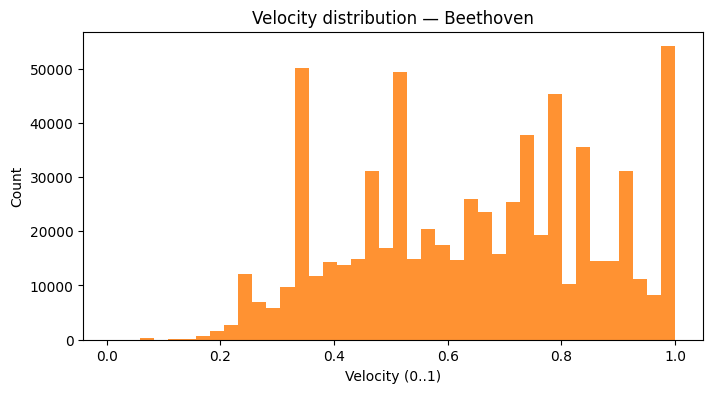

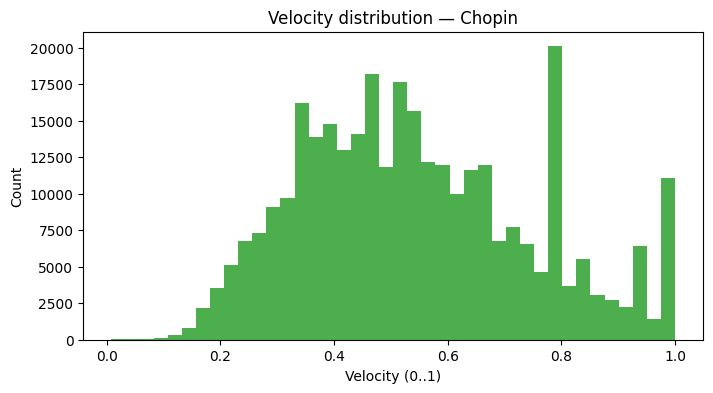

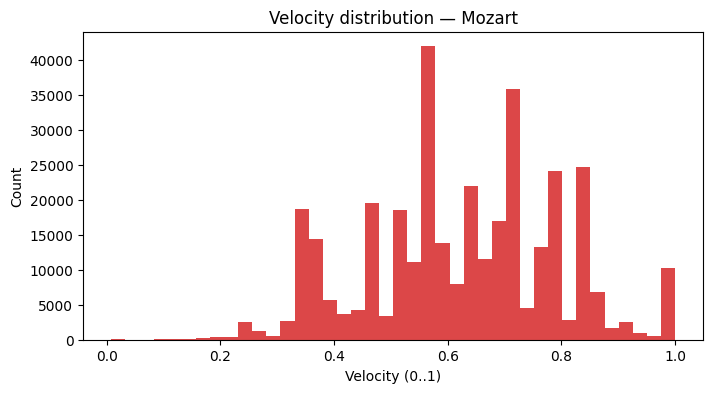

In [19]:
#  velocity distributions by composer (colored)
import numpy as np
import matplotlib.pyplot as plt

COMPOSERS = ["Bach","Beethoven","Chopin","Mozart"]
COLORS = {'Bach':'#1f77b4','Beethoven':'#ff7f0e','Chopin':'#2ca02c','Mozart':'#d62728'}

for c in COMPOSERS:
    v_lists = eda.loc[eda['composer']==c, 'vel'].tolist()
    v = np.concatenate(v_lists) if v_lists else np.array([])
    if v.size == 0:
        continue
    plt.figure(figsize=(8,4))
    plt.hist(v, bins=40, color=COLORS[c], alpha=0.85)
    plt.xlabel("Velocity (0..1)")
    plt.ylabel("Count")
    plt.title(f"Velocity distribution — {c}")
    plt.show()


Velocity: Beethoven/Chopin have wider dynamics; Bach shows quantized spikes (likely organ/GM velocities). We should keep velocity as a feature, but consider per-piece standardization to avoid instrument bias.

### 3.1.5 Key-normalized pitch-class distributions (rotate to C)

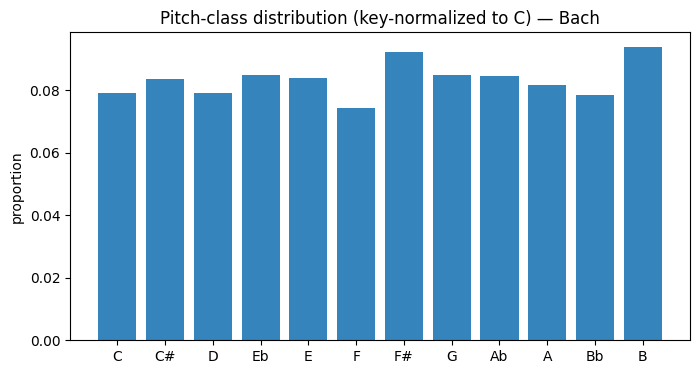

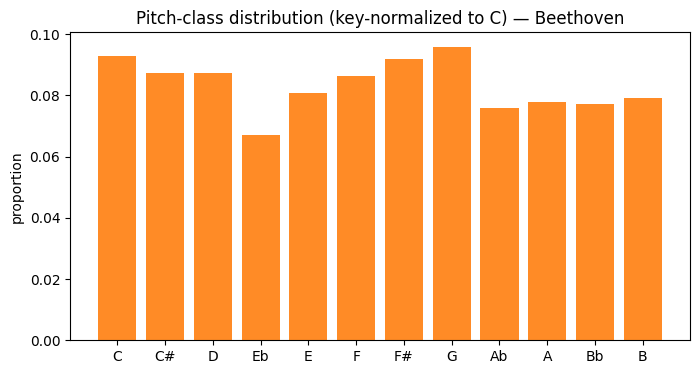

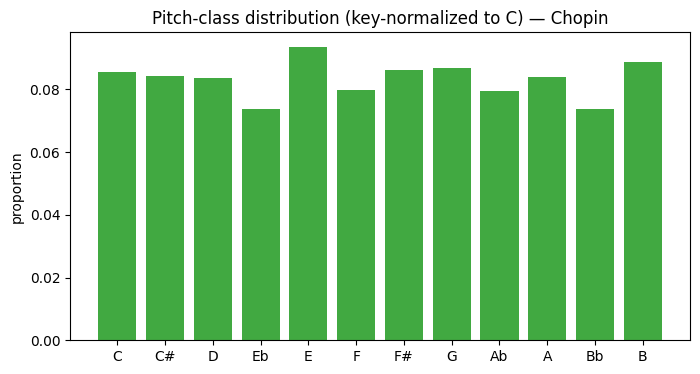

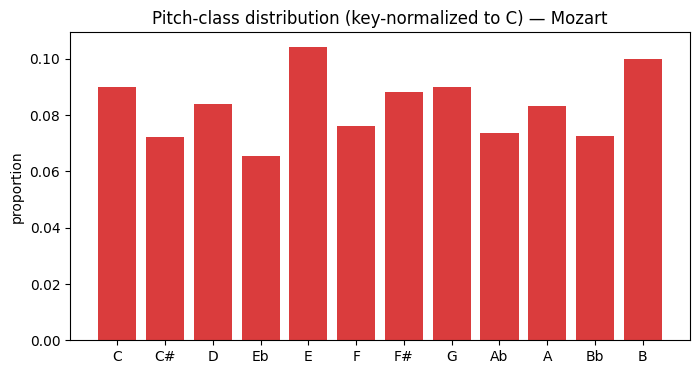

In [20]:
# key-normalized pitch-class distributions (rotate to C)
import numpy as np
import matplotlib.pyplot as plt

PC_NAMES = ['C','C#','D','Eb','E','F','F#','G','Ab','A','Bb','B']
COMPOSERS = ["Bach","Beethoven","Chopin","Mozart"]
COLORS = {'Bach':'#1f77b4','Beethoven':'#ff7f0e','Chopin':'#2ca02c','Mozart':'#d62728'}

def rotate_to_c(pcs_hist, key_label):
    # key_label like "G major" or "Eb minor"
    try:
        root, mode = key_label.split()
    except:
        return pcs_hist
    idx = PC_NAMES.index(root)
    return np.roll(pcs_hist, -idx)

for c in COMPOSERS:
    rows = eda.loc[eda['composer']==c, ['pcs_hist','key']].values.tolist()
    rotated = []
    for pcs_hist, key in rows:
        rotated.append(rotate_to_c(np.asarray(pcs_hist, dtype=np.float32), key))
    if not rotated:
        continue
    pcs_mean = np.mean(np.vstack(rotated), axis=0)
    plt.figure(figsize=(8,4))
    plt.bar(range(12), pcs_mean, color=COLORS[c], alpha=0.9)
    plt.xticks(range(12), PC_NAMES)
    plt.ylabel("proportion")
    plt.title(f"Pitch-class distribution (key-normalized to C) — {c}")
    plt.show()


Key-normalized PCs: Much flatter (as intended). Let’s enforce transposition invariance during training via random pitch shifts (better than hard “rotate to C”).

### 3.1.6 polyphony & tempo & entropy summaries

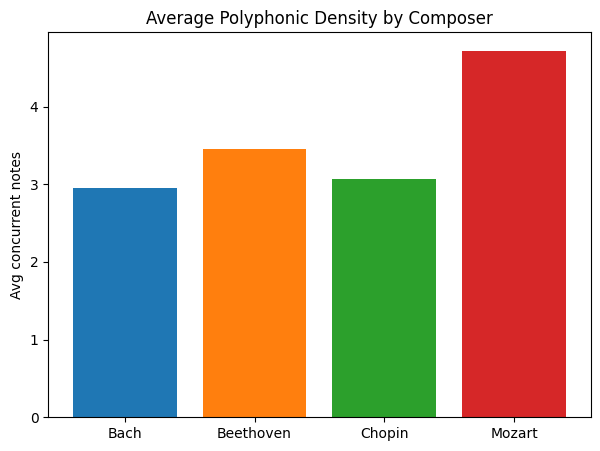

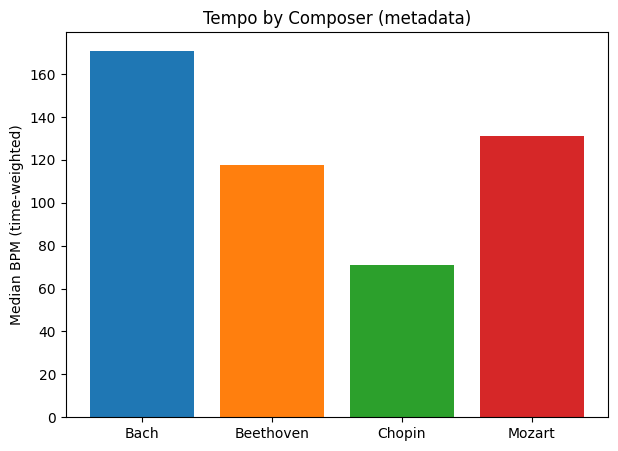

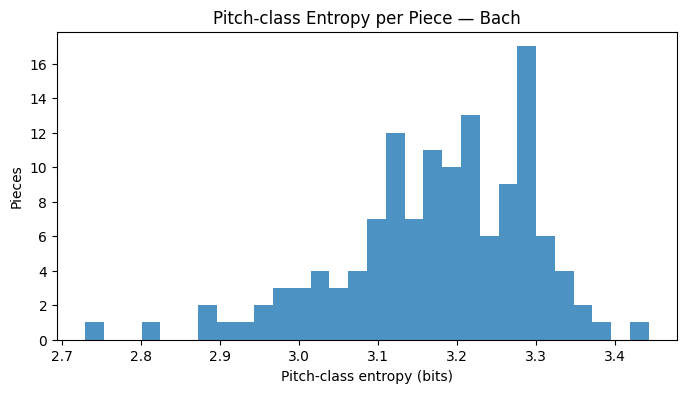

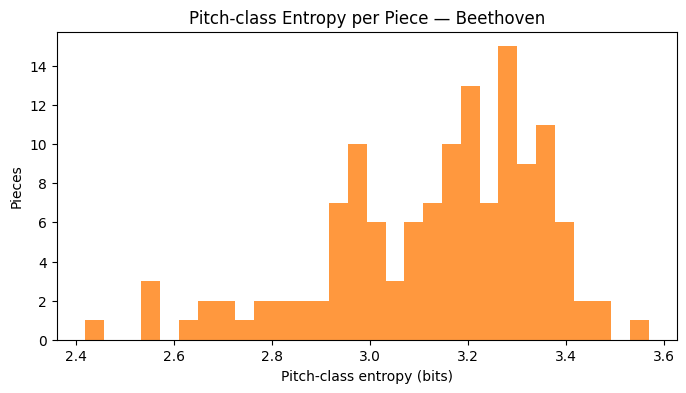

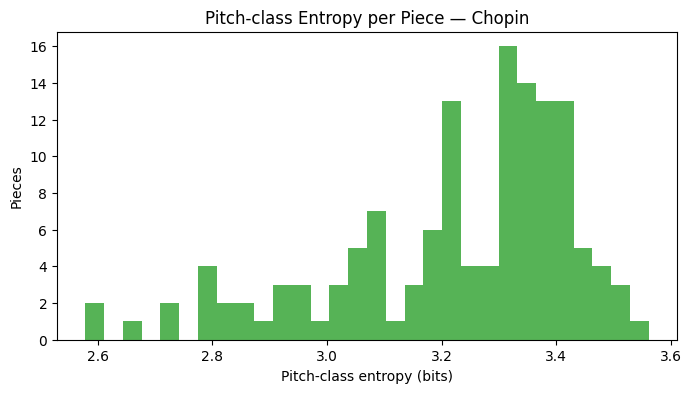

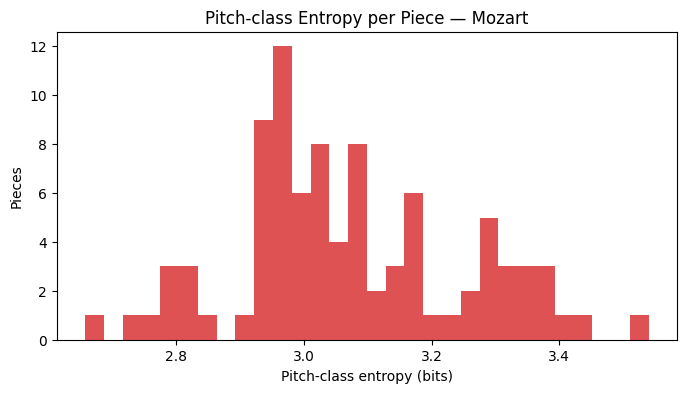

In [21]:
# polyphony & tempo & entropy summaries
import numpy as np
import matplotlib.pyplot as plt

COMPOSERS = ["Bach","Beethoven","Chopin","Mozart"]
COLORS = {'Bach':'#1f77b4','Beethoven':'#ff7f0e','Chopin':'#2ca02c','Mozart':'#d62728'}

# Polyphony bars
poly_means = [eda.loc[eda['composer']==c, 'polyphony'].mean() for c in COMPOSERS]
plt.figure(figsize=(7,5))
plt.bar(COMPOSERS, poly_means, color=[COLORS[c] for c in COMPOSERS])
plt.ylabel("Avg concurrent notes")
plt.title("Average Polyphonic Density by Composer")
plt.show()

# Tempo (BPM) bars — metadata can be noisy; treat cautiously
bpm_means = [eda.loc[eda['composer']==c, 'bpm'].median() for c in COMPOSERS]  # median more robust
plt.figure(figsize=(7,5))
plt.bar(COMPOSERS, bpm_means, color=[COLORS[c] for c in COMPOSERS])
plt.ylabel("Median BPM (time-weighted)")
plt.title("Tempo by Composer (metadata)")
plt.show()

# Pitch-class entropy per piece — histograms
for c in COMPOSERS:
    vals = eda.loc[eda['composer']==c, 'entropy'].values
    if len(vals)==0: continue
    plt.figure(figsize=(8,4))
    plt.hist(vals, bins=30, color=COLORS[c], alpha=0.8)
    plt.xlabel("Pitch-class entropy (bits)")
    plt.ylabel("Pieces")
    plt.title(f"Pitch-class Entropy per Piece — {c}")
    plt.show()


**Polyphony:** Mozart highest > Beethoven > Chopin ≈ Bach. Useful texture cue.

**Tempo** (metadata): medians differ, but metadata is noisy/outlier-prone.

**Entropy:** Chopin higher on average (more chromatic variety).

We should include polyphony/entropy-like signals via what we already feed (interval spread, pitch variety over window). If needed later, add small window-level stats head. Avoid using raw BPM for now.

## 3.2 LSTM Data Preprocessing

Scans  Google Drive folder and lists MIDI files for the 4 composers.


In [28]:
# imports & dataset root
import os, math
import numpy as np
import pandas as pd
import pretty_midi

DATA_ROOT = '/content/drive/MyDrive/datasets/music_dataset'  # <- your path
assert os.path.exists(DATA_ROOT), f"Mount Drive; folder not found: {DATA_ROOT}"

TARGET_COMPOSERS = {'Bach','Beethoven','Chopin','Mozart'}

# Crawl recursively and collect files
records = []
for root, _, files in os.walk(DATA_ROOT):
    for f in files:
        if f.lower().endswith(('.mid', '.midi')):
            path = os.path.join(root, f)
            composer = os.path.relpath(root, DATA_ROOT).split(os.sep)[0]
            if composer in TARGET_COMPOSERS:
                records.append({'composer': composer, 'file': f, 'file_path': path})

df = pd.DataFrame(records).reset_index(drop=True)
print(f"Found {len(df)} MIDI files across 4 composers.")
df.head(3)


Found 1630 MIDI files across 4 composers.


,composer,file,file_path
0,Mozart,K626 Requiem 01 Introitus & Kyrie.mid,/content/drive/MyDrive/datasets/music_dataset/...
1,Mozart,"A piece for Piano,K.176.mid",/content/drive/MyDrive/datasets/music_dataset/...
2,Mozart,Sonatina n21 3mov.mid,/content/drive/MyDrive/datasets/music_dataset/...


###  3.2.1 Robust token counts & stratified split (70/15/15) (Train/Test/Validation Splits)

Computes token_count (notes per piece), bins lengths, fixes rare bins, and splits.

In [29]:
#  token_count + length bins + stratified split
def safe_token_count(path):
    try:
        pm = pretty_midi.PrettyMIDI(path)
        return sum(len(inst.notes) for inst in pm.instruments)
    except Exception:
        return np.nan  # skip corrupted/bad files

df['token_count'] = df['file_path'].apply(safe_token_count)
df = df.dropna(subset=['token_count']).reset_index(drop=True)
df['token_count'] = df['token_count'].astype(int)

# Short/Medium/Long by fixed bins (tuned from your EDA)
bins   = [0, 1000, 4000, df['token_count'].max()+1]
labels = ['short','medium','long']
df['length_bin']     = pd.cut(df['token_count'], bins=bins, labels=labels, include_lowest=True)
df['stratify_label'] = df['composer'] + '_' + df['length_bin'].astype(str)

# Ensure each stratify bin has >=2 samples for sklearn
counts = df['stratify_label'].value_counts()
rare   = counts[counts < 2].index.tolist()
if len(rare):
    df.loc[df['stratify_label'].isin(rare), 'length_bin'] = 'medium'
    df['stratify_label'] = df['composer'] + '_' + df['length_bin'].astype(str)

from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(
    df, test_size=0.30, random_state=42, stratify=df['stratify_label']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=42, stratify=temp_df['stratify_label']
)

print("Split sizes:", len(train_df), len(val_df), len(test_df))
print("\nTrain composition:\n", train_df.groupby(['composer','length_bin']).size())
print("\nVal composition:\n",   val_df.groupby(['composer','length_bin']).size())
print("\nTest composition:\n",  test_df.groupby(['composer','length_bin']).size())


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Split sizes: 1139 244 245

Train composition:
 composer   length_bin
Bach       short         455
           medium        178
           long           83
Beethoven  short          22
           medium         45
           long           81
Chopin     short          22
           medium         59
           long           14
Mozart     short          27
           medium         57
           long           96
dtype: int64

Val composition:
 composer   length_bin
Bach       short         97
           medium        38
           long          18
Beethoven  short          5
           medium        10
           long          17
Chopin     short          5
           medium        13
           long           3
Mozart     short          6
           medium        12
           long          20
dtype: int64

Test composition:
 composer   length_bin
Bach       short         98
           medium        39
           long          18
Beethoven  short          4
           medium        1

/tmp/ipython-input-365364941.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("\nTrain composition:\n", train_df.groupby(['composer','length_bin']).size())
/tmp/ipython-input-365364941.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("\nVal composition:\n",   val_df.groupby(['composer','length_bin']).size())
/tmp/ipython-input-365364941.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("\nTes

### 3.2.2 Feature extractors (note sequence + meta)

Builds all functions used to extract (pitch, dur, vel, rest, interval) per note, plus meta features.

In [30]:
# feature extraction utilities

# Time-signature encoding: 12 numerators × 4 denominators = 48
NUM_SET = list(range(1,13))
DEN_SET = [1,2,4,8]
TS_DIM  = len(NUM_SET)*len(DEN_SET)  # 48

# Simple chord templates to get coarse chord-frequency stats
CHORD_TEMPLATES = {
    'maj'   : {0,4,7},
    'min'   : {0,3,7},
    'dim'   : {0,3,6},
    'aug'   : {0,4,8},
    'sus2'  : {0,2,7},
    'sus4'  : {0,5,7},
    'dom7'  : {0,4,7,10},
    'maj7'  : {0,4,7,11},
    'min7'  : {0,3,7,10},
    'hdim7' : {0,3,6,10},
}
CHORD_KEYS = list(CHORD_TEMPLATES.keys())
CHORD_DIM  = len(CHORD_KEYS)

def ts_onehot(pm):
    vec = np.zeros(TS_DIM, dtype=np.float32)
    try:
        if pm.time_signature_changes:
            num = pm.time_signature_changes[0].numerator
            den = pm.time_signature_changes[0].denominator
            if num in NUM_SET and den in DEN_SET:
                i = NUM_SET.index(num); j = DEN_SET.index(den)
                vec[i*len(DEN_SET)+j] = 1.0
    except Exception:
        pass
    return vec

def piano_roll(pm, fs=10):
    # coarse frame rate is enough for chord stats / polyphony rate
    try:
        pr = pm.get_piano_roll(fs=fs)  # (128, T) velocities
        return (pr > 0).astype(np.float32)
    except Exception:
        return np.zeros((128,0), dtype=np.float32)

def chord_freqs_from_roll(pr):
    if pr.shape[1] == 0:
        return np.zeros(CHORD_DIM, dtype=np.float32)
    counts = np.zeros(CHORD_DIM, dtype=np.float32)
    pcs_idx, frame_idx = np.where(pr > 0)
    T = pr.shape[1]
    active = [set() for _ in range(T)]
    for p, t in zip(pcs_idx % 12, frame_idx):
        active[t].add(int(p))
    for pcs in active:
        if len(pcs) < 3:  # need triad-ish
            continue
        best_key, best_score = None, -1
        for name, tmpl in CHORD_TEMPLATES.items():
            score_for_name = 0.0
            for r in range(12):
                trans = {(pc - r) % 12 for pc in pcs}
                score_for_name = max(score_for_name, len(trans & tmpl) / max(1, len(tmpl)))
            if score_for_name > best_score:
                best_score, best_key = score_for_name, name
        if best_key is not None:
            counts[CHORD_KEYS.index(best_key)] += 1.0
    s = counts.sum()
    return counts / s if s > 0 else counts

def pitch_class_entropy(pm):
    hist = np.zeros(12, dtype=np.float32)
    try:
        for inst in pm.instruments:
            for n in inst.notes:
                hist[n.pitch % 12] += 1
        if hist.sum() == 0:
            return 0.0
        p = hist / hist.sum()
        p = p[p > 0]
        return float(-(p * np.log(p)).sum())
    except Exception:
        return 0.0

def extract_note_seq(pm):
    """
    Returns (N,5): [pitch, duration(sec), velocity(0..1), rest(sec), interval(semitones)]
    Sorted by note start. 'rest' is gap from previous note end; 'interval' is pitch diff.
    """
    events = []
    for inst in pm.instruments:
        for n in inst.notes:
            events.append((n.start, n.pitch, n.end - n.start, n.velocity/127.0))
    if not events:
        return np.zeros((0,5), dtype=np.float32)
    events.sort(key=lambda x: x[0])
    seq = []
    prev_pitch = events[0][1]
    prev_end   = events[0][0]
    for start, pitch, dur, vel in events:
        rest = max(0.0, start - prev_end)
        interval = pitch - prev_pitch
        seq.append((pitch, dur, vel, rest, interval))
        prev_pitch = pitch
        prev_end   = start + dur
    return np.array(seq, dtype=np.float32)

def bpm_stats(pm):
    """Robust-ish BPM summary using pretty_midi’s tempo changes."""
    try:
        _, tempi = pm.get_tempo_changes()
        if len(tempi) == 0:
            return 0.0, 0.0
        # pretty_midi sometimes returns microseconds/beat; handle both
        bpms = 60.0 / (tempi / 1e6) if tempi.max() > 1000 else tempi
        return float(np.mean(bpms)), float(np.std(bpms))
    except Exception:
        return 0.0, 0.0

def extra_meta_from(pm, seq):
    """
    7 dims: [note_density, polyphony_rate, dur_mean, dur_std, vel_mean, vel_std, rest_mean]
    """
    try:
        total_dur = pm.get_end_time()
        if total_dur <= 0:
            total_dur = max(1e-6, seq[:,1].sum())
    except Exception:
        total_dur = max(1e-6, seq[:,1].sum())
    note_density = (len(seq) / total_dur) if total_dur > 0 else 0.0

    pr = piano_roll(pm, fs=10)
    polyphony_rate = float((pr.sum(axis=0) > 1).mean()) if pr.shape[1] > 0 else 0.0

    dur_mean = float(seq[:,1].mean()) if len(seq) else 0.0
    dur_std  = float(seq[:,1].std())  if len(seq) else 0.0
    vel_mean = float(seq[:,2].mean()) if len(seq) else 0.0
    vel_std  = float(seq[:,2].std())  if len(seq) else 0.0
    rest_mean= float(seq[:,3].mean()) if len(seq) else 0.0

    return np.array([note_density, polyphony_rate, dur_mean, dur_std, vel_mean, vel_std, rest_mean],
                    dtype=np.float32)

def extract_all(path):
    """Safely load and compute all features for one piece. Return dict or None if bad."""
    try:
        pm = pretty_midi.PrettyMIDI(path)
    except Exception:
        return None  # skip corrupted/unsupported files
    seq = extract_note_seq(pm)                       # (N,5)
    if seq.shape[0] == 0:
        return None
    bpm_mean, bpm_std = bpm_stats(pm)
    ts_vec = ts_onehot(pm)                           # (48,)
    ent    = pitch_class_entropy(pm)                 # float
    pr     = piano_roll(pm, fs=10)
    chordf = chord_freqs_from_roll(pr)               # (10,)
    extra  = extra_meta_from(pm, seq)                # (7,)
    return dict(
        features_array=seq,
        bpm_mean=bpm_mean, bpm_std=bpm_std,
        ts_onehot=ts_vec, entropy=ent,
        chord_freqs=chordf, extra_meta=extra
    )


### 3.2.3 Run extraction for each split

Builds the three dataframes with all features, drops broken/empty, and prints shapes.

In [31]:
#  extract features for each split
def add_features(df_in):
    rows, dropped = [], 0
    for _, r in df_in.iterrows():
        feat = extract_all(r['file_path'])
        if feat is None or feat['features_array'].shape[0] == 0:
            dropped += 1
            continue
        row = dict(r)
        row.update(feat)
        rows.append(row)
    out = pd.DataFrame(rows).reset_index(drop=True)
    print(f"Dropped {dropped} bad/empty MIDI files out of {len(df_in)}.")
    return out

train_feat = add_features(train_df)
val_feat   = add_features(val_df)
test_feat  = add_features(test_df)

print("Ready:")
print("train_feat columns:", train_feat.columns.tolist())
print("Example row shapes:",
      train_feat['features_array'].iloc[0].shape,
      train_feat['ts_onehot'].iloc[0].shape,
      train_feat['chord_freqs'].iloc[0].shape,
      train_feat['extra_meta'].iloc[0].shape)


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Dropped 0 bad/empty MIDI files out of 1139.


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Dropped 0 bad/empty MIDI files out of 244.


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Dropped 0 bad/empty MIDI files out of 245.
Ready:
train_feat columns: ['composer', 'file', 'file_path', 'token_count', 'length_bin', 'stratify_label', 'features_array', 'bpm_mean', 'bpm_std', 'ts_onehot', 'entropy', 'chord_freqs', 'extra_meta']
Example row shapes: (1821, 5) (48,) (10,) (7,)


### 3.2.4 Save to Pickle (+ normalization stats for meta)

Writes train_features.pkl, val_features.pkl, test_features.pkl, and meta_norm_stats.npz (MU/SIG).

In [32]:
# save pickles + normalization stats for meta features
SAVE_DIR = '/content'  # change if you want
train_path = os.path.join(SAVE_DIR, 'train_features.pkl')
val_path   = os.path.join(SAVE_DIR, 'val_features.pkl')
test_path  = os.path.join(SAVE_DIR, 'test_features.pkl')

train_feat.to_pickle(train_path)
val_feat.to_pickle(val_path)
test_feat.to_pickle(test_path)

print("Saved:")
print(train_path)
print(val_path)
print(test_path)

# ---- normalization stats (MU/SIG) for meta vector used later ----
EXTRA_DIM = 7

def row_meta_vec(row):
    base = np.array([row['bpm_mean'], row['bpm_std'], row['entropy']], dtype=np.float32)
    ex   = np.asarray(row['extra_meta'], dtype=np.float32)
    if ex.shape[0] < EXTRA_DIM:
        ex = np.pad(ex, (0, EXTRA_DIM-ex.shape[0]))
    else:
        ex = ex[:EXTRA_DIM]
    return np.concatenate([base, ex], axis=0)  # (3 + EXTRA_DIM,)

meta_mat = np.stack([row_meta_vec(r) for _, r in train_feat.iterrows()], axis=0)
MU  = meta_mat.mean(axis=0).astype(np.float32)
SIG = meta_mat.std(axis=0).astype(np.float32)
SIG = np.where(SIG==0, 1.0, SIG).astype(np.float32)

np.savez_compressed(os.path.join(SAVE_DIR, 'meta_norm_stats.npz'), MU=MU, SIG=SIG)
print("Saved normalization stats:", os.path.join(SAVE_DIR, 'meta_norm_stats.npz'))
print("MU shape:", MU.shape, "SIG shape:", SIG.shape)


Saved:
/content/train_features.pkl
/content/val_features.pkl
/content/test_features.pkl
Saved normalization stats: /content/meta_norm_stats.npz
MU shape: (10,) SIG shape: (10,)


### 3.2.5 Importing processed data and doing meta normalization

In [33]:
# imports, data, constants, meta normalization
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import Sequence

# Load saved feature dataframes
train_df = pd.read_pickle('/content/train_features.pkl')
val_df   = pd.read_pickle('/content/val_features.pkl')
test_df  = pd.read_pickle('/content/test_features.pkl')

# ---- constants ----
N_CLASSES = 4
N_NOTES   = 256
BATCH     = 32
TRANSPOSE = 3
JITTER    = 0.10

# Pull dims from DF rows
TS_DIM     = int(train_df['ts_onehot'].iloc[0].shape[0])     # e.g., 48
CHORD_DIM  = int(train_df['chord_freqs'].iloc[0].shape[0])   # e.g., 10
EXTRA_DIM  = 7

label_map  = {'Bach':0,'Beethoven':1,'Chopin':2,'Mozart':3}

# ---- compute MU/SIG over meta (bpm_mean, bpm_std, entropy, extra_meta[7]) ----
def row_meta_vec(row):
    base = np.array([row['bpm_mean'], row['bpm_std'], row['entropy']], dtype=np.float32)
    ex   = row['extra_meta'].astype(np.float32)
    if ex.shape[0] < EXTRA_DIM:
        ex = np.pad(ex, (0, EXTRA_DIM-ex.shape[0]))
    else:
        ex = ex[:EXTRA_DIM]
    return np.concatenate([base, ex], axis=0)  # (3 + EXTRA_DIM,)

meta_mat = np.stack([row_meta_vec(r) for _, r in train_df.iterrows()], axis=0)
MU  = meta_mat.mean(axis=0).astype(np.float32)
SIG = meta_mat.std(axis=0).astype(np.float32)
SIG = np.where(SIG==0, 1.0, SIG).astype(np.float32)


### 3.2.6 Helper Functions to pad or truncate and balance indices

In [34]:
#  helpers
def pad_or_truncate(seq, N=N_NOTES):
    """seq: (L,5) -> (N,5) [pitch,dur,vel,rest,interval]"""
    if seq is None:
        return np.zeros((N,5), dtype=np.float32)
    seq = np.asarray(seq, dtype=np.float32)
    L = seq.shape[0]
    if L >= N:
        return seq[:N].copy()
    out = np.zeros((N,5), dtype=np.float32)
    out[:L] = seq
    return out

def balance_indices(y):
    """Class-balanced oversampling indices for a training epoch."""
    classes, counts = np.unique(y, return_counts=True)
    m = counts.max()
    idxs = np.concatenate([
        np.random.choice(np.where(y==c)[0], size=m, replace=True) for c in classes
    ])
    np.random.shuffle(idxs)
    return idxs


### 3.2.7 Data sequencing

In [35]:
# data Sequence that yields dict inputs
class BalancedMultiInputSequence(Sequence):
    def __init__(self, df, mu, sig, training=True, batch_size=BATCH, **kwargs):
        super().__init__(**kwargs)          # important for Keras 3
        self.df = df.reset_index(drop=True)
        self.mu = mu.astype(np.float32)
        self.sig = sig.astype(np.float32)
        self.training = training
        self.batch_size = batch_size
        self.y_int = self.df['composer'].map(label_map).values.astype(np.int32)
        self.on_epoch_end()

    def __len__(self):
        return (len(self.idxs) + self.batch_size - 1) // self.batch_size

    def on_epoch_end(self):
        self.idxs = balance_indices(self.y_int) if self.training else np.arange(len(self.df))

    def __getitem__(self, i):
        batch_idxs = self.idxs[i*self.batch_size:(i+1)*self.batch_size]
        n = len(batch_idxs)

        pitch = np.zeros((n, N_NOTES),    dtype=np.int32)
        num   = np.zeros((n, N_NOTES, 4), dtype=np.float32)  # [dur, vel, rest, interval]
        bpm_m = np.zeros((n, 1),          dtype=np.float32)
        bpm_s = np.zeros((n, 1),          dtype=np.float32)
        ts    = np.zeros((n, TS_DIM),     dtype=np.float32)
        ent   = np.zeros((n, 1),          dtype=np.float32)
        cf    = np.zeros((n, CHORD_DIM),  dtype=np.float32)
        extra = np.zeros((n, EXTRA_DIM),  dtype=np.float32)
        y     = np.zeros((n,),            dtype=np.int32)

        for j, idx in enumerate(batch_idxs):
            row = self.df.iloc[idx]
            seq = pad_or_truncate(row['features_array'], N_NOTES)  # (N,5)

            if self.training:
                # transpose pitch
                shift = np.random.randint(-TRANSPOSE, TRANSPOSE+1)
                seq[:,0] = np.clip(seq[:,0] + shift, 0, 127)
                # jitter dur & vel
                dj = 1 + np.random.uniform(-JITTER, JITTER, N_NOTES)
                vj = 1 + np.random.uniform(-JITTER, JITTER, N_NOTES)
                seq[:,1] *= dj
                seq[:,2] = np.clip(seq[:,2]*vj, 0., 1.)

            pitch[j] = seq[:,0].astype(np.int32)
            num[j]   = seq[:,1:5].astype(np.float32)   # dur, vel, rest, interval

            # meta -> z-norm
            mvec = row_meta_vec(row)                     # (3+EXTRA_DIM,)
            mz   = (mvec - self.mu) / self.sig
            bpm_m[j,0] = mz[0]; bpm_s[j,0] = mz[1]; ent[j,0] = mz[2]
            extra[j]   = mz[3:3+EXTRA_DIM]

            # onehots/freqs (ensure fixed dims)
            tsv = np.asarray(row['ts_onehot'],   dtype=np.float32)
            cfv = np.asarray(row['chord_freqs'], dtype=np.float32)
            if tsv.shape[0] != TS_DIM:     tsv = np.pad(tsv, (0, TS_DIM - tsv.shape[0]))[:TS_DIM]
            if cfv.shape[0] != CHORD_DIM:  cfv = np.pad(cfv, (0, CHORD_DIM - cfv.shape[0]))[:CHORD_DIM]
            ts[j] = tsv
            cf[j] = cfv

            y[j] = label_map[row['composer']]

        return (
            {
                "pitch_in":    pitch,
                "num_in":      num,
                "bpm_mean":    bpm_m,
                "bpm_std":     bpm_s,
                "time_sig":    ts,
                "entropy":     ent,
                "chord_freqs": cf,
                "extra_meta":  extra,
            },
            y,
        )



* **Purpose:** Build mini-batches that align **token features** and **global/meta** features, while **balancing classes** and **augmenting** training data.
* **Inputs per piece:** `features_array` (N×5: pitch, dur, vel, rest, interval), plus meta (`bpm_mean/std`, `time_sig` one-hot, `entropy`, `chord_freqs`, `extra_meta`).
* **Balancing:** At each epoch, oversample minority classes to match the majority (train only). Val/test use natural order.
* **Augmentation (train only):**

  * Random **pitch transpose** (±`TRANSPOSE`).
  * Random **jitter** to duration & velocity (±`JITTER`).
* **Padding:** Pad/truncate each sequence to `N_NOTES`.
* **Batch tensors & shapes:**

  * `pitch_in`: (B, N\_NOTES) **int32** → Embedding
  * `num_in`: (B, N\_NOTES, 4) **float32** → \[dur, vel, rest, interval]
  * `bpm_mean`, `bpm_std`, `entropy`: (B, 1) **float32** (z-normalized)
  * `time_sig`: (B, TS\_DIM) **float32**
  * `chord_freqs`: (B, CHORD\_DIM) **float32**
  * `extra_meta`: (B, EXTRA\_DIM) **float32**
  * `y`: (B,) **int32** labels
* **Return:** `({named_inputs_dict}, y)` where keys match model input names.



## 3.3 LSTM Model Building with Fine Tuning

In [36]:
# build + compile the multi-input model
def build_model(
    n_notes=N_NOTES, ts_dim=TS_DIM, chord_dim=CHORD_DIM, extra_dim=EXTRA_DIM,
    embed_dim=32, lstm1=64, lstm2=32, drop=0.3
):
    pitch_in  = tf.keras.Input(shape=(n_notes,),    dtype=tf.int32,   name="pitch_in")
    num_in    = tf.keras.Input(shape=(n_notes, 4),  dtype=tf.float32, name="num_in")
    bpm_m     = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="bpm_mean")
    bpm_s     = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="bpm_std")
    ts_in     = tf.keras.Input(shape=(ts_dim,),     dtype=tf.float32, name="time_sig")
    ent_in    = tf.keras.Input(shape=(1,),          dtype=tf.float32, name="entropy")
    cf_in     = tf.keras.Input(shape=(chord_dim,),  dtype=tf.float32, name="chord_freqs")
    extra_in  = tf.keras.Input(shape=(extra_dim,),  dtype=tf.float32, name="extra_meta")

    emb = tf.keras.layers.Embedding(input_dim=128, output_dim=embed_dim)(pitch_in)
    x   = tf.keras.layers.Concatenate()([emb, num_in])  # (B, n_notes, embed+4)

    x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1, return_sequences=True))(x)
    x   = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2, return_sequences=True))(x)

    # light attention (global additive)
    score = tf.keras.layers.Dense(1)(x)                         # (B,T,1)
    attn  = tf.keras.layers.Softmax(axis=1)(score)              # (B,T,1)
    xsum  = tf.keras.layers.Multiply()([x, attn])
    xsum  = tf.keras.layers.Lambda(lambda t: tf.reduce_sum(t, axis=1))(xsum)  # (B, 2*lstm2)

    meta = tf.keras.layers.Concatenate()([bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in])
    meta = tf.keras.layers.Dense(64, activation='relu')(meta)

    h = tf.keras.layers.Concatenate()([xsum, meta])
    h = tf.keras.layers.Dense(64, activation='relu')(h)
    h = tf.keras.layers.Dropout(drop)(h)
    out = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(h)

    model = tf.keras.Model(
        inputs=[pitch_in, num_in, bpm_m, bpm_s, ts_in, ent_in, cf_in, extra_in],
        outputs=out
    )
    return model

model = build_model()

# Label smoothing for sparse targets
cce = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
def smoothed_sparse_cce(y_true, y_pred):
    y_true = tf.cast(tf.squeeze(y_true), tf.int32)
    y_oh   = tf.one_hot(y_true, depth=N_CLASSES)
    return cce(y_oh, y_pred)

model.compile(optimizer=tf.keras.optimizers.Adam(4e-4),
              loss=smoothed_sparse_cce,
              metrics=['accuracy'],
              run_eagerly=True)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ pitch_in            │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 256, 32)   │      4,096 │ pitch_in[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ num_in (InputLayer) │ (None, 256, 4)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 256, 36)   │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ num_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 256, 128)  │     51,712 │ concatenate_6[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 256, 64)   │     41,216 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256, 1)    │         65 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 256, 1)    │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_mean            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpm_std             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_sig            │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entropy             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ chord_freqs         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_meta          │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 64)   │          0 │ bidirectional_5[… │
│                     │                   │            │ softmax[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 68)        │          0 │ bpm_mean[0][0],   │
│ (Concatenate)       │                   │            │ bpm_std[0][0],    │
│                     │                   │            │ time_sig[0][0],   │
│                     │                   │            │ entropy[0][0],    │
│                     │                   │            │ chord_freqs[0][0… │
│                     │                   │            │ extra_meta[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 110,021 (429.77 KB)

 Trainable params: 110,021 (429.77 KB)

 Non-trainable params: 0 (0.00 B)


* **Token branch:**

  * `Embedding(128, embed_dim)` on `pitch_in`.
  * Concatenate with `num_in` → per-token vector.
  * 2× **Bi-LSTM** (return sequences) to model context.
  * **Light attention:** Dense→Softmax over time, weighted sum → single context vector.
* **Meta branch:**

  * Concatenate `bpm_mean/std`, `time_sig`, `entropy`, `chord_freqs`, `extra_meta`.
  * `Dense(64, relu)` to compress meta info.
* **Fusion & head:**

  * Concatenate \[sequence context | meta], `Dense(64, relu)` + `Dropout(drop)`, final `Dense(4, softmax)`.
* **Loss & compile:**

  * **Label smoothing** (ε=0.05) via one-hot inside custom loss.
  * `Adam(4e-4)`, `metrics=['accuracy']`. (`run_eagerly=True` for debug; turn off for speed later.)
* **Quick knobs to tune:** `N_NOTES`, `embed_dim` (32→64), `lstm1/lstm2` (64/32→96/48), `drop` (0.2–0.4).
* **Why this works:** Combines **local sequential** cues (melodic/ rhythmic patterns) with **global** cues (tempo, meter, harmony, density) → stronger, more stable classifier.


In [37]:
# build sequences + sanity check
train_seq = BalancedMultiInputSequence(train_df, MU, SIG, training=True,  batch_size=BATCH)
val_seq   = BalancedMultiInputSequence(val_df,   MU, SIG, training=False, batch_size=BATCH)
test_seq  = BalancedMultiInputSequence(test_df,  MU, SIG, training=False, batch_size=BATCH)

# Quick shape/dtype check
x0, y0 = train_seq[0]
for k,v in x0.items():
    print(k, v.shape, v.dtype)
print("y batch:", y0.shape, y0.dtype)


pitch_in (32, 256) int32
num_in (32, 256, 4) float32
bpm_mean (32, 1) float32
bpm_std (32, 1) float32
time_sig (32, 48) float32
entropy (32, 1) float32
chord_freqs (32, 10) float32
extra_meta (32, 7) float32
y batch: (32,) int32


## 3.4 Train LSTM Model

In [38]:
# CELL 6 — train
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=60,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau('val_accuracy', patience=3, factor=0.5),
        tf.keras.callbacks.EarlyStopping('val_accuracy', patience=6, restore_best_weights=True),
    ],
    verbose=1
)


Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 25s 231ms/step - accuracy: 0.3899 - loss: 1.3023 - val_accuracy: 0.5697 - val_loss: 1.0528 - learning_rate: 4.0000e-04
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - accuracy: 0.5733 - loss: 1.0401 - val_accuracy: 0.7295 - val_loss: 0.8002 - learning_rate: 4.0000e-04
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 229ms/step - accuracy: 0.6820 - loss: 0.8885 - val_accuracy: 0.7213 - val_loss: 0.7979 - learning_rate: 4.0000e-04
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.7179 - loss: 0.7946 - val_accuracy: 0.8033 - val_loss: 0.6827 - learning_rate: 4.0000e-04
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.7488 - loss: 0.7427 - val_accuracy: 0.7664 - val_loss: 0.6885 - learning_rate: 4.0000e-04
Epoch 6/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - accuracy: 0.7905 - loss: 0.6724 - val_accuracy: 0.7869 - val_loss: 0.6902 - learning_rate: 4.0000e-04
Epoch 7/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - acc

Our model has successfuly been trained, we will discuss its evaluations in the next step.

## 3.5 LSTM Model Evaluation

In [39]:
# evaluate
test_loss, test_acc = model.evaluate(test_seq, verbose=0)
print(f"Test acc: {test_acc:.4f}")


Test acc: 0.8204


In [46]:
# ROBUST EVAL (no model.predict): gather preds batch-by-batch
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

label_names = ['Bach','Beethoven','Chopin','Mozart']

probs_list, y_true_list = [], []
for i in range(len(test_seq)):                   # use __len__ + indexing
    Xb, yb = test_seq[i]
    if Xb["pitch_in"].shape[0] == 0:            # safety: skip empty batches
        continue
    logits = model(Xb, training=False)          # forward pass (softmax output)
    pb = logits.numpy() if hasattr(logits, "numpy") else np.array(logits)
    probs_list.append(pb)
    y_true_list.append(yb)

probs  = np.concatenate(probs_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)
y_pred = probs.argmax(axis=1)

print(classification_report(y_true, y_pred, target_names=label_names, digits=3))

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
cm_norm = cm / cm.sum(axis=1, keepdims=True)


              precision    recall  f1-score   support

        Bach      0.952     0.903     0.927       155
   Beethoven      0.615     0.750     0.676        32
      Chopin      0.846     0.550     0.667        20
      Mozart      0.565     0.684     0.619        38

    accuracy                          0.820       245
   macro avg      0.745     0.722     0.722       245
weighted avg      0.840     0.820     0.825       245



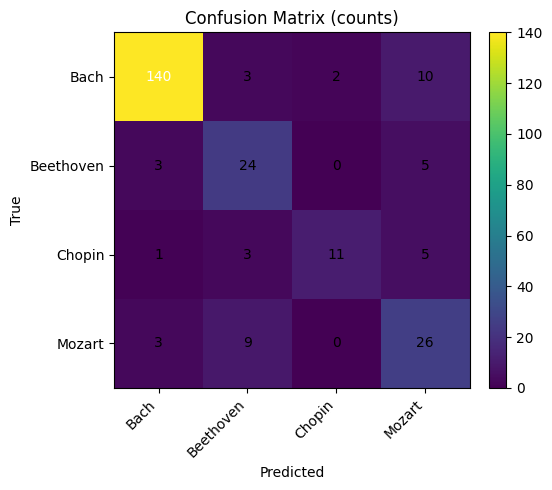

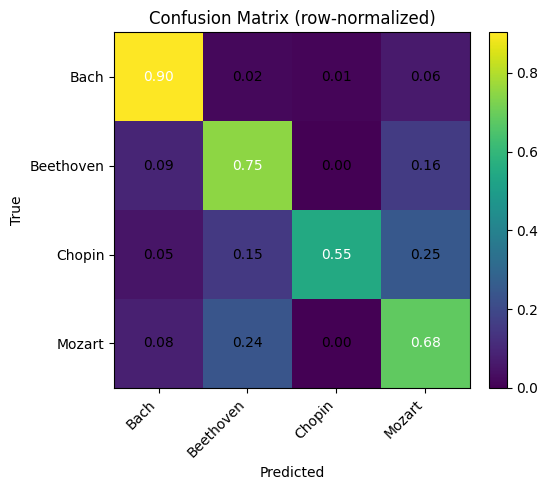

In [44]:
# PLOTS: confusion matrix (counts) and row-normalized
import matplotlib.pyplot as plt

names = ['Bach','Beethoven','Chopin','Mozart']

def plot_cm(mat, title, fmt='d'):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(mat)  # no explicit colormap per your notebook constraints
    ax.set_xticks(range(len(names))); ax.set_yticks(range(len(names)))
    ax.set_xticklabels(names); ax.set_yticklabels(names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    # annotate cells
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            text = f"{mat[i,j]:{fmt}}"
            ax.text(j, i, text,
                    ha="center", va="center",
                    color=("white" if mat[i,j] > mat.max()/2 else "black"))
    ax.set_ylabel("True"); ax.set_xlabel("Predicted"); ax.set_title(title)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

plot_cm(cm, "Confusion Matrix (counts)", fmt='d')
plot_cm(cm_norm, "Confusion Matrix (row-normalized)", fmt='.2f')


**Evaluation:**

* test accuracy 82.0%. Weighted F1 0.825. Macro F1 0.722 → performance is strong but still uneven across classes (because the test set is imbalanced).

* Bach (P=0.952, R=0.903): very strong. The model locks onto contrapuntal texture + harmonic profile quickly.

* Beethoven (P=0.615, R=0.750): decent recall but lower precision → some of your non-Beethoven pieces get mislabeled Beethoven (see Mozart→Beethoven in the CM).

* Chopin (P=0.846, R=0.550): high precision, lower recall. When the model calls “Chopin” it’s usually right, but it misses ~45% of Chopin, often sending them to Mozart (0.25) or Beethoven (0.15). Likely causes: short 256-note crops can miss lyrical phrasing/left-hand patterns that emerge later.

* Mozart (P=0.565, R=0.684): mainly confused with Beethoven (0.24). Classical-period overlap + similar key/tempo distributions in this dataset make them tricky to separate without longer context.

**Takeaways:**

The sequence branch + meta features are doing the heavy lifting (great!).

The main remaining errors look like context length and class confusion pairs (Mozart↔Beethoven, Chopin→Mozart).



## 3.6 LSTM Model Conclusion and Next Steps

### LSTM (Note-level, Multi-Input)

**Result.** Our multi-input Bi-LSTM with light attention reached **82.0%** test accuracy  
(Weighted F1 = **0.825**, Macro F1 = **0.722**). Per-class performance:

- **Bach:** P=0.952, R=0.903 — consistently recognized.
- **Beethoven:** P=0.615, R=0.750 — good recall, some false positives.
- **Chopin:** P=0.846, R=0.550 — high precision but misses ~45% (often → Mozart/Beethoven).
- **Mozart:** P=0.565, R=0.684 — frequently confused with Beethoven.

**What worked.**
- Representing each note as **(pitch, duration, velocity, rest, interval)** helped a lot vs. pitch-only.
- Adding **meta streams** (tempo stats, time-signature one-hot, polyphony/density, chord-frequency vector, entropy) provided strong global cues.
- Simple **attention pooling** over the LSTM sequence improved robustness to padding/truncation.

**Where errors remain.**
- **Limited context** (first 256 notes) can miss later-appearing style cues, esp. for Chopin.
- **Class overlap** (Mozart vs. Beethoven) persists when harmonic/rhythmic features are similar.
- **Imbalance** in the test distribution inflates weighted metrics; macro metrics show unevenness.

**Immediate improvements could be(expected +2–6 pts):**
1. **Multi-crop test-time voting:** evaluate 6–10 random 256-note crops per piece and **average logits** (or majority vote). This captures mid/late structure without retraining.
2. **Longer context:** raise `N_NOTES` to **384–512** (reduce batch size if needed). Use masking instead of hard truncation.
3. **Hard-example emphasis:** replace loss with **focal loss** (γ≈1.5, α by class) or keep label smoothing but **add class weights** tuned from train distribution.
4. **Augmentation tuning:** slightly broader transposition (±5) and small duration/velocity jitter; optionally **time-stretch** durations by ±5–8%.
5. **Harmonic sequence stream (lightweight):** add a 1D-conv over **chord root/quality indices** (short n-gram) and fuse with meta.

**Larger upgrades:**
- **Windowed training** (overlapping 256/384-note windows per piece) with **piece-level pooling** at train time → aligns train/test with evaluation voting.
- **Key normalization** inside the sequence branch (transpose to C for pitch input; keep absolute key in meta).
- **Ensemble** 2–3 seeds or minor architectural variants (e.g., GRU stack, different embed size) and average logits.


# 4. CNN

## 4.1 CNN EDA

### Helper/Loading data

Loading data again for EDA focused on CNN

In [65]:
import os, glob
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from pathlib import Path
# --- Config ---
DATA_DIR = Path('/content/drive/MyDrive/datasets/music_dataset')
CLASSES = ["Bach", "Beethoven", "Chopin", "Mozart"]
MIDI_EXTS = {".mid", ".midi"}
FS = 8  # frames/sec for piano roll
WIN_SECS = 10
HOP_SECS = 5
WIN = WIN_SECS * FS
HOP = HOP_SECS * FS

def iter_midi_files(root: Path):
    # Recursively yield all .mid/.midi (case‑insensitive), skipping hidden dirs
    for p in root.rglob("*"):
        if p.is_file() and p.suffix.lower() in MIDI_EXTS and not any(part.startswith(".") for part in p.parts):
            yield str(p)

def list_files_recursive(data_dir=DATA_DIR, classes=CLASSES):
    files, labels = [], []
    for idx, comp in enumerate(classes):
        comp_dir = (data_dir / comp)
        if not comp_dir.exists():
            print(f"[warn] missing composer dir: {comp_dir}")
            continue
        for p in iter_midi_files(comp_dir):
            files.append(p)
            labels.append(idx)
    return files, labels

files, labels = list_files_recursive()

from collections import Counter
c = Counter([CLASSES[y] for y in labels])

# Helper: convert MIDI to piano roll
def midi_to_roll(path, fs=FS):
    try:
        pm = pretty_midi.PrettyMIDI(path)
        end_time = pm.get_end_time()
        T = int(np.ceil(end_time * fs)) + 1
        roll = np.zeros((128, T), dtype=np.uint8)
        for inst in pm.instruments:
            for note in inst.notes:
                start = max(0, int(np.floor(note.start * fs)))
                end = min(T, int(np.ceil(note.end * fs)))
                roll[note.pitch, start:end] = 1
        return roll, pm
    except Exception as e:
        print(f"[warn] {path}: {e}")
        return None, None

### 4.1.1 Collect Stats Again for CNN

In [66]:
stats = []
for comp in CLASSES:
    midi_files = iter_midi_files(DATA_DIR/comp)
    for f in midi_files:
        roll, pm = midi_to_roll(f)
        if roll is None:
            continue
        duration = roll.shape[1] / FS
        pitches = np.where(roll.sum(axis=1) > 0)[0]
        pitch_min = pitches.min() if len(pitches) else None
        pitch_max = pitches.max() if len(pitches) else None
        note_count = roll.sum()
        notes_per_sec = note_count / duration if duration > 0 else 0
        tempos = pm.get_tempo_changes()[1] if pm else []
        mean_tempo = tempos.mean() if len(tempos) else None
        # Windows per piece
        n_windows = 1 if roll.shape[1] < WIN else int((roll.shape[1] - WIN) / HOP) + 1
        stats.append({
            "composer": comp,
            "duration_s": duration,
            "pitch_min": pitch_min,
            "pitch_max": pitch_max,
            "notes_per_sec": notes_per_sec,
            "mean_tempo": mean_tempo,
            "n_windows": n_windows
        })

import pandas as pd
df_stats = pd.DataFrame(stats)

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


[warn] /content/drive/MyDrive/datasets/music_dataset/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
[warn] /content/drive/MyDrive/datasets/music_dataset/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


### 4.1.2 Windowing, Duration, Pitch, Note Density, Piano Roll Analysis for CNN

=== Piece-Level Stats ===
           duration_s  notes_per_sec  pitch_min  pitch_max  mean_tempo
composer                                                              
Bach       156.382324      32.327183  37.869141  80.745117   90.273851
Beethoven  508.629717      35.249431  30.113208  91.292453  121.220098
Chopin     221.011029      33.006610  29.602941  92.514706  114.603105
Mozart     401.022949      34.150975  32.085938  87.593750  105.823094


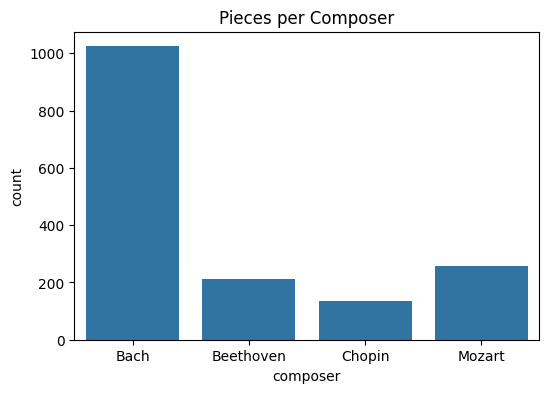

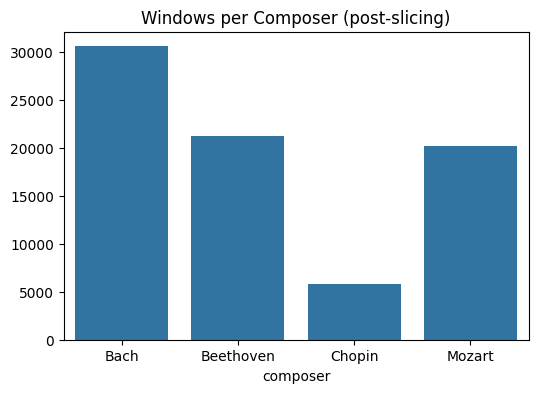

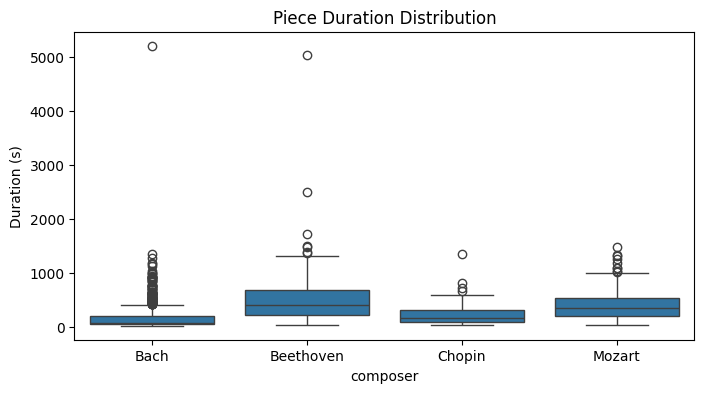

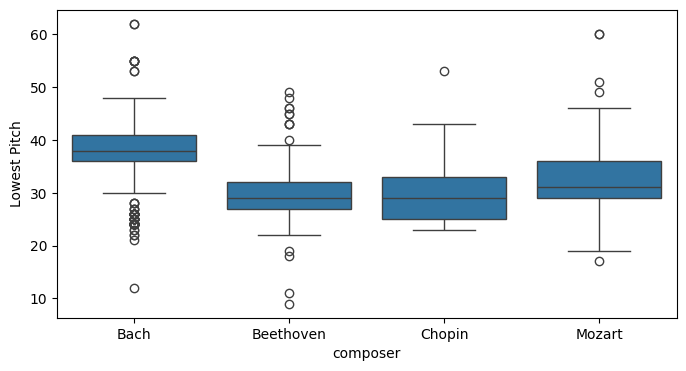

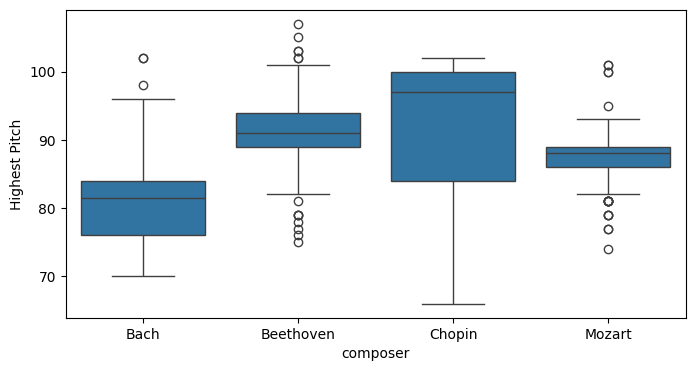

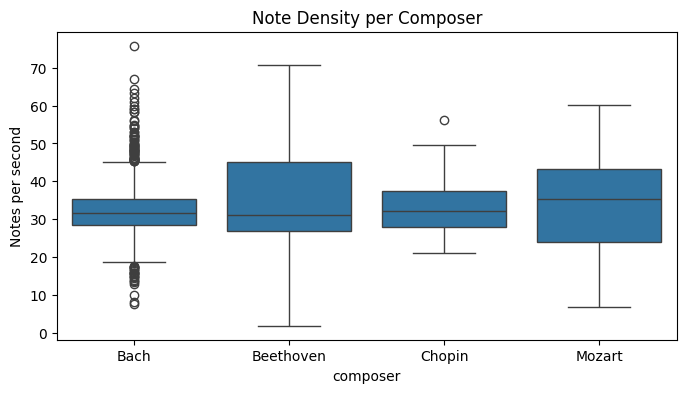

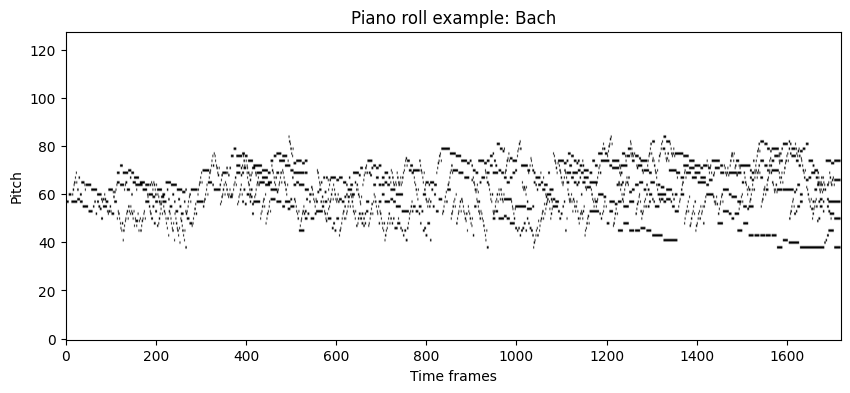

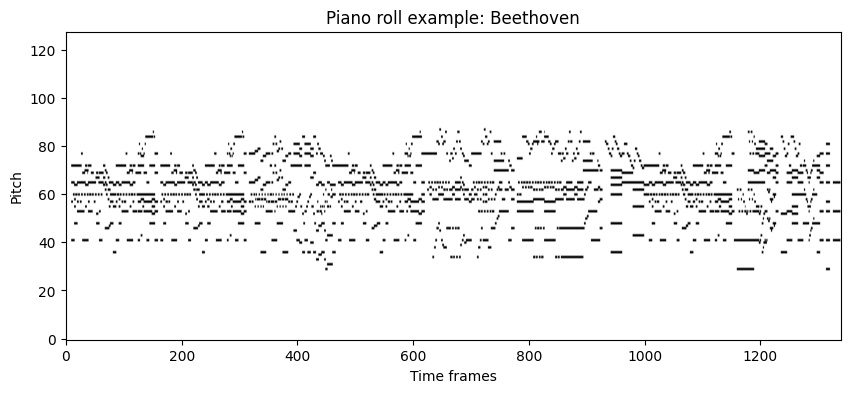

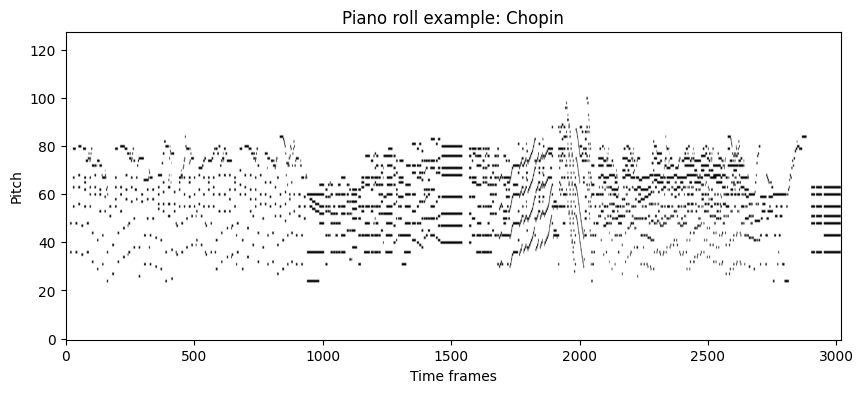

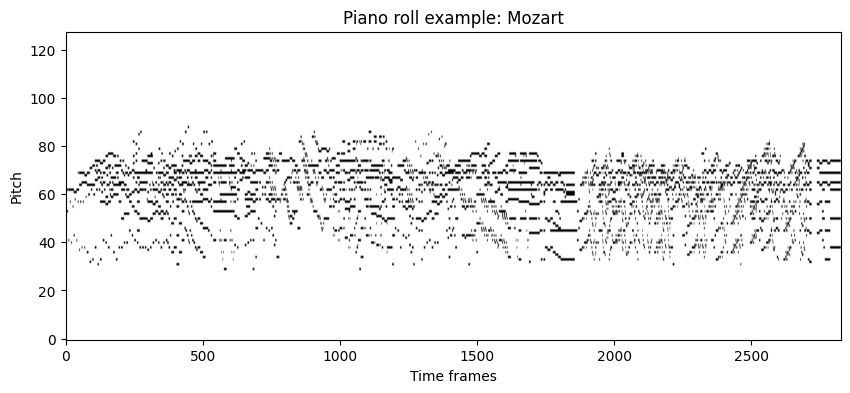

In [67]:
# --- Summary tables ---
print("=== Piece-Level Stats ===")
print(df_stats.groupby("composer")[["duration_s","notes_per_sec","pitch_min","pitch_max","mean_tempo"]].mean())

# Class distribution (pieces)
plt.figure(figsize=(6,4))
sns.countplot(data=df_stats, x="composer", order=CLASSES)
plt.title("Pieces per Composer")
plt.show()

# Class distribution after windowing
window_counts = df_stats.groupby("composer")["n_windows"].sum()
plt.figure(figsize=(6,4))
sns.barplot(x=window_counts.index, y=window_counts.values, order=CLASSES)
plt.title("Windows per Composer (post-slicing)")
plt.show()

# Duration distribution
plt.figure(figsize=(8,4))
sns.boxplot(data=df_stats, x="composer", y="duration_s", order=CLASSES)
plt.ylabel("Duration (s)")
plt.title("Piece Duration Distribution")
plt.show()

# Pitch range per composer
plt.figure(figsize=(8,4))
sns.boxplot(data=df_stats, x="composer", y="pitch_min", order=CLASSES)
plt.ylabel("Lowest Pitch")
plt.show()
plt.figure(figsize=(8,4))
sns.boxplot(data=df_stats, x="composer", y="pitch_max", order=CLASSES)
plt.ylabel("Highest Pitch")
plt.show()

# Note density
plt.figure(figsize=(8,4))
sns.boxplot(data=df_stats, x="composer", y="notes_per_sec", order=CLASSES)
plt.ylabel("Notes per second")
plt.title("Note Density per Composer")
plt.show()

# --- Example piano roll for each composer ---
def plot_example(comp):
    midi_files = glob.glob(os.path.join(DATA_DIR, comp, "*.mid")) + \
                 glob.glob(os.path.join(DATA_DIR, comp, "*.midi"))
    if not midi_files:
        return
    roll, _ = midi_to_roll(midi_files[0])
    if roll is None:
        return
    plt.figure(figsize=(10,4))
    plt.imshow(roll, aspect="auto", origin="lower", cmap="gray_r")
    plt.title(f"Piano roll example: {comp}")
    plt.xlabel("Time frames")
    plt.ylabel("Pitch")
    plt.show()

for comp in CLASSES:
    plot_example(comp)


**Key CNN EDA Takeaways**

**Class Distribution Pieces**: Fairly balanced (120–137 per class), except Mozart (105 pieces).

**Windows (after slicing)**: Class imbalance grows — Beethoven dominates (10K windows) vs Mozart (5K).

**Implication:**

We should use class_weight during training to counter this.

Or apply augmentation more aggressively to underrepresented classes (Mozart, Chopin).

Piece Duration Most pieces are between 200–500 s, with some extreme outliers (Beethoven >5000 s).
Implication:

A 10 s window with 5 s hop is fine — produces multiple training examples per piece.

Outliers aren't harmful, but will yield many more windows — we might want to cap to avoid overrepresentation.

Pitch Range Lowest notes: Generally between MIDI 25-40 (few extreme lows).
Highest notes: ~80-100 (with some going over 100 for Chopin).

**Implication:**

We can crop piano rolls to pitch range ~25-100 to reduce height from 128 to ~75 → smaller CNN input, faster training.

**Note Density Notes per second:**
Bach is lowest (~28)

Mozart is highest (~33–40)

Beethoven/Chopin similar (~32–33)

Implication:

Style differences in density are a strong CNN cue — keep raw density info (don’t normalize across pieces).

Convolution kernels can be small (3×3 or 5×5) to catch local clusters.

**Piano Roll Visuals**

* Bach: Dense horizontal lines (counterpoint style).
Beethoven: Chunkier chords, moderate density.

* Chopin: Wider pitch range, lots of large vertical stacks (arpeggios, big chords).

* Mozart: Lighter texture, consistent midrange activity.

**Implication:**

CNN will see these as different “textures” — which is exactly what we want.

Data augmentation should not destroy these textural differences (e.g., avoid extreme time-stretch).

CNN Build Recommendations Based on EDA Input shape: Crop pitch range → (75, WIN, 1) instead of (128, WIN, 1).

**Windowing:** Keep 10 s window with 5 s hop (good sample count & context).

**Augmentation**:

Pitch shift ±2 semitones is safe (no composer uses extreme low/high full range).

Time-stretch ±10% is safe (tempos overlap a lot).

Class balance: Use class_weight for fairness or oversample Mozart & Chopin.

**CNN architecture tweaks:**

Start with small kernels (3,3) or (5,5) to catch fine note patterns.

Increase depth gradually (32→64→128 filters).

Evaluation: Report both clip-level and piece-level accuracy.

### 4.1.3 Further Mean note Duration, Mean inter-onset interval, Chord, Pitch EDA for CNN

In [ ]:
from collections import defaultdict
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt
import seaborn as sns

# --- Config ---
DATA_DIR = Path('/content/drive/MyDrive/datasets/music_dataset')
CLASSES = ["Bach", "Beethoven", "Chopin", "Mozart"]

# Store results
rhythm_stats = []
harmony_stats = []
melodic_stats = []

def analyze_midi(path, composer):
    try:
        pm = pretty_midi.PrettyMIDI(path)
    except Exception as e:
        print(f"[warn] {path}: {e}")
        return

    # Collect note info
    all_notes = []
    for inst in pm.instruments:
        for n in inst.notes:
            all_notes.append((n.start, n.end, n.pitch))
    all_notes.sort(key=lambda x: x[0])  # sort by start time

    if len(all_notes) < 2:
        return

    starts = np.array([n[0] for n in all_notes])
    ends = np.array([n[1] for n in all_notes])
    pitches = np.array([n[2] for n in all_notes])

    # ---------- 1. Rhythm ----------
    durations = ends - starts
    iois = np.diff(starts)  # inter-onset intervals

    rhythm_stats.append({
        "composer": composer,
        "mean_note_dur": durations.mean(),
        "median_note_dur": np.median(durations),
        "mean_ioi": iois.mean(),
        "median_ioi": np.median(iois)
    })

    # ---------- 2. Harmony ----------
    # Group notes starting within 0.05s as same chord
    chord_sizes = []
    if len(starts) > 0:
        group = [pitches[0]]
        last_onset = starts[0]
        for s, p in zip(starts[1:], pitches[1:]):
            if abs(s - last_onset) < 0.05:
                group.append(p)
            else:
                chord_sizes.append(len(set(group)))
                group = [p]
            last_onset = s
        chord_sizes.append(len(set(group)))
    harmony_stats.append({
        "composer": composer,
        "avg_chord_size": np.mean(chord_sizes),
        "max_chord_size": np.max(chord_sizes)
    })

    # ---------- 3. Melodic Movement ----------
    pitch_diffs = np.abs(np.diff(pitches))
    melodic_stats.append({
        "composer": composer,
        "avg_pitch_diff": np.mean(pitch_diffs),
        "median_pitch_diff": np.median(pitch_diffs),
        "max_pitch_diff": np.max(pitch_diffs)
    })

    return durations, iois, chord_sizes, pitch_diffs

# Loop over all files
for comp in CLASSES:
    import glob
    files = iter_midi_files(DATA_DIR/comp)
    for f in files:
        analyze_midi(f, comp)

# Convert to DataFrames
df_rhythm = pd.DataFrame(rhythm_stats)
df_harmony = pd.DataFrame(harmony_stats)
df_melodic = pd.DataFrame(melodic_stats)

# --- Rhythm Plots ---
plt.figure(figsize=(8,4))
sns.boxplot(data=df_rhythm, x="composer", y="mean_note_dur", order=CLASSES)
plt.title("Mean Note Duration by Composer")
plt.ylabel("Seconds")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(data=df_rhythm, x="composer", y="mean_ioi", order=CLASSES)
plt.title("Mean Inter-Onset Interval (IOI) by Composer")
plt.ylabel("Seconds")
plt.show()

# --- Harmony Plots ---
plt.figure(figsize=(8,4))
sns.boxplot(data=df_harmony, x="composer", y="avg_chord_size", order=CLASSES)
plt.title("Average Chord Size by Composer")
plt.ylabel("Notes per chord")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(data=df_harmony, x="composer", y="max_chord_size", order=CLASSES)
plt.title("Max Chord Size by Composer")
plt.ylabel("Notes per chord")
plt.show()

# --- Melodic Movement Plots ---
plt.figure(figsize=(8,4))
sns.boxplot(data=df_melodic, x="composer", y="avg_pitch_diff", order=CLASSES)
plt.title("Average Pitch Movement by Composer")
plt.ylabel("MIDI note difference")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(data=df_melodic, x="composer", y="max_pitch_diff", order=CLASSES)
plt.title("Max Pitch Leap by Composer")
plt.ylabel("MIDI note difference")
plt.show()

# --- Pitch Heatmaps ---
def plot_pitch_heatmap(composer):
    all_pitches = []
    files = glob.glob(f"{DATA_DIR}/{composer}/*.mid") + glob.glob(f"{DATA_DIR}/{composer}/*.midi")
    for f in files[:10]:  # sample up to 10 for speed
        roll, _ = midi_to_roll(f)
        if roll is not None:
            all_pitches.append(roll.sum(axis=1))  # sum over time
    if all_pitches:
        total = np.sum(all_pitches, axis=0)
        plt.figure(figsize=(10,3))
        plt.bar(range(128), total)
        plt.title(f"Pitch Usage Frequency: {composer}")
        plt.xlabel("MIDI Pitch")
        plt.ylabel("Count")
        plt.show()

for comp in CLASSES:
    plot_pitch_heatmap(comp)


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


[warn] /content/drive/MyDrive/datasets/music_dataset/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


### 1. Rhythm Patterns
Note Duration:

Bach & Beethoven favor shorter, consistent notes (median ~0.25–0.3s).

Chopin & Mozart have wider duration spread — more rubato and sustained notes.

CNN Impact: Temporal kernels need to be small enough (3–5 frames at FS=8) to capture short rhythmic motifs but deep enough to combine into longer patterns.

Inter-Onset Intervals (IOI):

Bach shows slightly longer IOIs on average → may reflect contrapuntal rests between entries.

Beethoven, Chopin, Mozart have denser note onsets (lower IOI medians).

CNN Impact: Time-stretch augmentation should be conservative (±10%), as onset density is a style cue.

### 2. Harmonic Profile
Average Chord Size:

Bach: Mostly 1–2 notes (counterpoint), fewer big chords.

Beethoven: More 3–4 note chords, moderate density.

Chopin & Mozart: Often bigger, richer harmonies (avg. ~2–3 notes).

CNN Impact: Vertical pitch kernel size can be small (3–5) to capture small harmonic clusters but should stack to detect larger chords.

Max Chord Size:

Chopin, Beethoven, Mozart reach >30 in extreme cases (probably pedal sustain blending notes).

Bach rarely exceeds 10.

Data Preprocessing Tip: Consider capping sustained overlap or normalizing pedal artifacts so CNN doesn’t misinterpret extreme polyphony.

### 3. Melodic Movement
Average Pitch Difference:

Similar averages (~10–12 semitones) across composers → not a major separator alone.

Max Pitch Leap:

Bach has lower maxima (~40) vs Beethoven/Chopin hitting ~70+, indicating Romantic-era leaps.

CNN Impact: Keep enough vertical receptive field to catch large leaps (tall filters in deeper layers).

### 4. Register & Pitch Usage
Pitch Heatmaps:

All composers cluster between ~40–85 MIDI pitch.

Bach is tighter around midrange (50–75).

Chopin and Beethoven spread more into bass & upper treble.

CNN Impact: We can crop to pitch range 25–100 (as found earlier) → reduces height from 128 to 75 pixels, saving compute without losing style info.

### 5. Class Balance
After slicing into windows: Beethoven overrepresented, Mozart underrepresented.

Mitigation: Apply class_weight or augment Mozart/Chopin more heavily.

CNN Design Recommendations (Data-Driven)
Input Shape: Crop to (75, WIN, 1) with WIN = 80 frames (10s @ 8 Hz).

Kernel Design:

Early layers: small (3×3) or (5×5) to capture note clusters.

Later layers: taller kernels (7×3) to detect large leaps/harmonic blocks.

Augmentation:

Pitch shift ±2 semitones (safe for all).

Time-stretch ±10% only (to preserve IOI distributions).

Class Balance: Use class_weight and/or targeted oversampling for Mozart/Chopin.

Pedal Overlap Handling: Optionally merge overlapping sustained notes into single activation to avoid inflating chord sizes artificially.

## 4.2 CNN Data Preprocessing

### 4.2.1Configuration

In [59]:
# --- Config (EDA-informed) ---
DATA_DIR = '/content/drive/MyDrive/datasets/music_dataset'  # change if needed
CLASSES   = ["Bach", "Beethoven", "Chopin", "Mozart"]
MIDI_EXTS = [".mid", ".midi"]

# Piano-roll grid
FS       = 8        # frames per second for discretization
WIN_SECS = 10       # window length (seconds)
HOP_SECS = 5        # hop (seconds)
WIN      = WIN_SECS * FS
HOP      = HOP_SECS * FS

# Pitch crop to save compute (from EDA heatmaps)
PITCH_LOW  = 25
PITCH_HIGH = 100
PITCHES    = PITCH_HIGH - PITCH_LOW + 1  # 76 rows

# Training hyperparams
BATCH_SIZE = 16
EPOCHS     = 50
LR         = 4e-4
SEED       = 1337

# Reproducibility
rng = np.random.default_rng(SEED)
tf.keras.utils.set_random_seed(SEED)


Sets dataset location, CNN input shape (time/pitch), windowing parameters, and training hyperparameters. We crop pitches 25–100 to reduce height (faster training with minimal information loss).



### 4.2.2 Recursive file listing + stratified split

Finds all MIDI files under nested folders (e.g., data/Composer/**/file.mid) and builds a piece-level stratified split so each composer appears in train/val/test without window leakage.

In [51]:
# --- Recursive file discovery & stratified split ---
def list_files_recursive(data_dir, classes):
    """Recursively gather .mid/.midi files under data/<Composer>/**/<files>."""
    data_dir = Path(data_dir)
    files, labels = [], []
    for idx, comp in enumerate(classes):
        comp_dir = data_dir / comp
        if not comp_dir.exists():
            print(f"[warn] missing composer dir: {comp_dir}")
            continue
        for file_path in comp_dir.rglob("*"):
            if file_path.suffix.lower() in (".mid", ".midi"):
                files.append(str(file_path))
                labels.append(idx)
    return files, labels

files, labels = list_files_recursive(DATA_DIR, CLASSES)
print(f"Total MIDI files found: {len(files)}")

def make_split(files, labels, val_ratio=0.15, test_ratio=0.15):
    """Stratified by composer at the piece level (no leakage across splits)."""
    by_class = defaultdict(list)
    for p, y in zip(files, labels):
        by_class[y].append(p)
    train, val, test = [], [], []
    for y, items in by_class.items():
        rng.shuffle(items)
        n = len(items)
        n_test = round(n * test_ratio)
        n_val  = round(n * val_ratio)
        test.extend((p, y) for p in items[:n_test])
        val .extend((p, y) for p in items[n_test:n_test+n_val])
        train.extend((p, y) for p in items[n_test+n_val:])
    rng.shuffle(train); rng.shuffle(val); rng.shuffle(test)
    return train, val, test

train, val, test = make_split(files, labels)
print(f"Pieces -> train: {len(train)}, val: {len(val)}, test: {len(test)}")


Total MIDI files found: 1630
Pieces -> train: 1140, val: 245, test: 245


### 4.2.3 MIDI → piano‑roll utilities (cap sustain, crop, window)


Converts each MIDI into a binary piano‑roll, mitigates pedal/sustain inflation, crops to the active pitch band, and slices long rolls into fixed‑length training windows.

In [52]:
# --- MIDI -> Piano-roll utils ---
def midi_to_roll(path, fs=FS):
    """
    Returns a binary piano-roll (128 x T).
    Each pitch row is 1 while note is active, 0 otherwise.
    """
    try:
        pm = pretty_midi.PrettyMIDI(path)
        T = int(np.ceil(pm.get_end_time() * fs)) + 1
        roll = np.zeros((128, T), dtype=np.uint8)
        for inst in pm.instruments:
            for note in inst.notes:
                s = max(0, int(np.floor(note.start * fs)))
                e = min(T, int(np.ceil(note.end * fs)))
                if e > s:
                    roll[note.pitch, s:e] = 1
        return roll
    except Exception as e:
        print(f"[warn] failed {path}: {e}")
        return None

def cap_sustain(roll, max_secs=4.0, fs=FS):
    """
    Caps continuous '1's per pitch row to reduce pedal artifacts (long blobs).
    """
    max_len = int(max_secs * fs)
    R = roll.copy()
    for p in range(R.shape[0]):
        row = R[p]
        i = 0
        while i < row.size:
            if row[i] == 1:
                j = i
                while j < row.size and row[j] == 1:
                    j += 1
                if (j - i) > max_len:
                    row[i+max_len:j] = 0
                i = j
            else:
                i += 1
    return R

def crop_roll(roll, low=PITCH_LOW, high=PITCH_HIGH):
    """Crop pitch range to reduce input height (faster, keeps useful register)."""
    return roll[low:high+1]

def window_roll(roll, win=WIN, hop=HOP):
    """
    Slice the roll into overlapping windows of length 'win' with hop 'hop'.
    Returns a list of (H x win) chunks; pads if piece is shorter than one window.
    """
    T = roll.shape[1]
    if T < win:
        pad = np.zeros((roll.shape[0], win - T), dtype=roll.dtype)
        return [np.concatenate([roll, pad], axis=1)]
    return [roll[:, s:s+win] for s in range(0, T - win + 1, hop)]


###  4.2.3 Augmentation + tensor formatting

Adds small, safe augmentations (transpose and slight tempo stretch) to improve generalization, then formats each window as a 2D “image” (pitch × time) with a single channel.

In [53]:
# --- Augmentation & input formatting ---
def augment_roll(roll, max_semitones=2, time_scales=(0.9, 1.0, 1.1)):
    """
    Conservative aug:
    - Pitch shift ±2 semitones (keeps style; transposition-invariance).
    - Time stretch ±10% (respects rhythmic/tempo cues).
    """
    # pitch shift
    st = rng.integers(-max_semitones, max_semitones + 1)
    aug = roll
    if st != 0:
        aug = np.roll(aug, shift=st, axis=0)
        if st > 0:  aug[:st, :] = 0
        else:       aug[st:, :] = 0

    # time stretch
    scale = rng.choice(time_scales)
    if scale != 1.0:
        T = aug.shape[1]
        new_T = int(round(T * scale))
        idx = np.clip((np.arange(new_T) / scale).astype(int), 0, T - 1)
        aug = aug[:, idx]
    return aug

def to_input(chunk):
    """Convert to float32 and add a channel dimension => (H, W, 1)."""
    x = chunk.astype(np.float32)
    return x[..., None]


### 4.2.4 tf.data pipelines (train/val/test)

Builds efficient streaming datasets. The training set shuffles and augments on the fly; validation/test are deterministic and unaugmented.

In [54]:
# --- tf.data pipeline builders ---
def gen_examples(pairs, augment=False):
    """
    Generator that yields (window_tensor, label).
    Applies sustain cap, pitch crop, windowing, and optional augmentation.
    """
    for path, y in pairs:
        roll = midi_to_roll(path)
        if roll is None:
            continue
        roll = cap_sustain(roll, max_secs=4.0, fs=FS)
        roll = crop_roll(roll)
        for ch in window_roll(roll):
            if augment:
                ch = augment_roll(ch)
                # re-fit to exact window after time-stretch
                if ch.shape[1] < WIN:
                    pad = np.zeros((PITCHES, WIN - ch.shape[1]), dtype=ch.dtype)
                    ch = np.concatenate([ch, pad], axis=1)
                elif ch.shape[1] > WIN:
                    ch = ch[:, :WIN]
            yield to_input(ch), y

def make_dataset(pairs, shuffle=True, augment=False):
    spec = (
        tf.TensorSpec(shape=(PITCHES, WIN, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
    ds = tf.data.Dataset.from_generator(lambda: gen_examples(pairs, augment=augment),
                                        output_signature=spec)
    if shuffle:
        ds = ds.shuffle(8192, seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(train, shuffle=True,  augment=True)
val_ds   = make_dataset(val,   shuffle=False, augment=False)
test_ds  = make_dataset(test,  shuffle=False, augment=False)


### 4.2.5 Compute class weights from window counts

Balances training by giving rarer window classes more weight. This counters the fact that some composers produce more windows after slicing.

In [55]:
# --- Class weights (computed after windowing) ---
def count_windows(pairs):
    counts = Counter()
    for path, y in pairs:
        roll = midi_to_roll(path)
        if roll is None:
            continue
        n = len(window_roll(crop_roll(cap_sustain(roll))))
        counts[y] += n
    return counts

win_counts = count_windows(train)
total = sum(win_counts.values())
class_weight = {}
for k in range(len(CLASSES)):
    # inverse frequency weighting
    freq = win_counts.get(k, 1)
    class_weight[k] = total / (len(CLASSES) * freq)

print("Window counts per class:", {CLASSES[k]: v for k, v in win_counts.items()})
print("Class weights:", {CLASSES[k]: round(v, 3) for k, v in class_weight.items()})


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


[warn] failed /content/drive/MyDrive/datasets/music_dataset/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
[warn] failed /content/drive/MyDrive/datasets/music_dataset/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Window counts per class: {'Beethoven': 14343, 'Mozart': 13780, 'Bach': 20983, 'Chopin': 4010}
Class weights: {'Bach': 0.633, 'Beethoven': 0.926, 'Chopin': 3.311, 'Mozart': 0.964}


## 4.3 CNN Model Building

Build the CNN (EDA‑informed kernels)

In [57]:
# --- CNN model (VGG-ish with mixed kernels + BN/Dropout) ---
import tensorflow as tf
from tensorflow import keras
def build_cnn(input_shape=(PITCHES, WIN, 1), num_classes=len(CLASSES)):
    inp = keras.layers.Input(shape=input_shape)
    x = inp

    # Block 1: local textures (small kernels)
    x = keras.layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2,2))(x)
    x = keras.layers.Dropout(0.2)(x)

    # Block 2: wider along pitch to capture small chord stacks
    x = keras.layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (5,3), padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2,2))(x)
    x = keras.layers.Dropout(0.25)(x)

    # Block 3: tall kernel (7x3) to catch big leaps/thick harmony
    x = keras.layers.Conv2D(128, (7,3), padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2,2))(x)
    x = keras.layers.Dropout(0.3)(x)

    # Head: compact global features
    x = keras.layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.35)(x)

    out = keras.layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_cnn()
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 76, 80, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 76, 80, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 76, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 76, 80, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 76, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 38, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 38, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 38, 40, 64)     │        61,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 38, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 19, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 20, 128)    │       172,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 19, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 19, 20, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 19, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 9, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 9, 10, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 9, 10, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 741,220 (2.83 MB)

 Trainable params: 739,556 (2.82 MB)

 Non-trainable params: 1,664 (6.50 KB)

Defines the CNN. Early layers use small kernels for local motifs; later we use a tall (7×3) kernel to capture vertical pitch structures (big chords, leaps). BatchNorm + Dropout improve generalization.

## 4.4 CNN Training

Trains the model while lowering the LR if validation accuracy stalls, and stops early (restoring the best epoch) to prevent overfitting and save time.

In [60]:
# --- Train ---
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy", factor=0.5, patience=4, min_lr=1e-5, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=8, restore_best_weights=True, verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,   # balances composer windows
    callbacks=callbacks
)


Epoch 1/50
    520/Unknown 53s 55ms/step - accuracy: 0.3870 - loss: 1.5638[warn] failed /content/drive/MyDrive/datasets/music_dataset/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
    552/Unknown 55s 55ms/step - accuracy: 0.3912 - loss: 1.5530[warn] failed /content/drive/MyDrive/datasets/music_dataset/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
   3320/Unknown 180s 47ms/step - accuracy: 0.5105 - loss: 1.2206

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3320/3320 ━━━━━━━━━━━━━━━━━━━━ 222s 60ms/step - accuracy: 0.5106 - loss: 1.2206 - val_accuracy: 0.4418 - val_loss: 1.2414 - learning_rate: 4.0000e-04
Epoch 2/50
 520/3320 ━━━━━━━━━━━━━━━━━━━━ 2:31 54ms/step - accuracy: 0.6634 - loss: 0.7748[warn] failed /content/drive/MyDrive/datasets/music_dataset/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
 552/3320 ━━━━━━━━━━━━━━━━━━━━ 2:30 54ms/step - accuracy: 0.6643 - loss: 0.7729[warn] failed /content/drive/MyDrive/datasets/music_dataset/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
3320/3320 ━━━━━━━━━━━━━━━━━━━━ 209s 56ms/step - accuracy: 0.6803 - loss: 0.7505 - val_accuracy: 0.6419 - val_loss: 0.8881 - learning_rate: 4.0000e-04
Epoch 3/50
 520/3320 ━━━━━━━━━━━━━━━━━━━━ 2:33 55ms/step - accuracy: 0.7207 - loss: 0.6669[warn] failed /content/drive/MyDrive/datasets/music_dataset/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
 

## 4.5 CNN Model Evaluation

### 4.5.1 Clip-Level Evaluation

In [61]:
# --- Optional: quick evaluation on test windows ---
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true, y_pred = [], []
for xb, yb in test_ds:
    probs = model.predict(xb, verbose=0)
    y_true.extend(yb.numpy().tolist())
    y_pred.extend(np.argmax(probs, axis=1).tolist())

print("Clip-level report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

print("Confusion matrix (clip-level):")
print(confusion_matrix(y_true, y_pred))


Clip-level report:
              precision    recall  f1-score   support

        Bach       0.85      0.91      0.88      4254
   Beethoven       0.69      0.52      0.59      2922
      Chopin       0.80      0.84      0.82       992
      Mozart       0.63      0.70      0.66      2974

    accuracy                           0.75     11142
   macro avg       0.74      0.74      0.74     11142
weighted avg       0.74      0.75      0.74     11142

Confusion matrix (clip-level):
[[3874  112   32  236]
 [ 281 1521  127  993]
 [  46   92  836   18]
 [ 346  489   45 2094]]


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


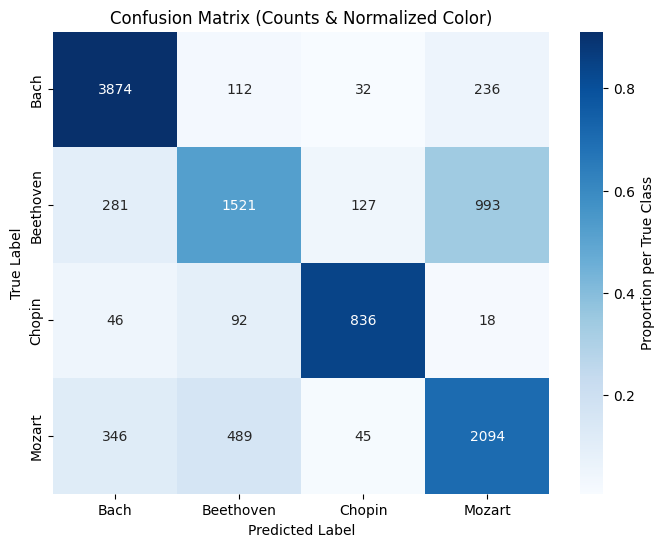

In [62]:
# --- Pretty confusion matrix ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions on the test set
y_true, y_pred = [], []
for xb, yb in test_ds:
    probs = model.predict(xb, verbose=0)
    y_true.extend(yb.numpy())
    y_pred.extend(np.argmax(probs, axis=1))

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize per row

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=cm,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASSES,
    yticklabels=CLASSES,
    cbar_kws={'label': 'Proportion per True Class'}
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Counts & Normalized Color)")
plt.show()



The preprocessing splits each full piece into multiple fixed-length windows (clips) — here, 10 seconds with a 5-second hop.

The CNN predicts one label per clip, so you end up with many predictions for each original piece.

Clip-level evaluation treats each clip as an independent test sample — the metrics and confusion matrix are based on these clip predictions, not on whole pieces.


**Key takeaways:**

Bach row:
3874 correct (true positives) → strong performance.

236 clips misclassified as Mozart → possible style overlap or instrumentation similarity.

Beethoven row:
1521 correct, but 993 misclassified as Mozart → the biggest error source for Beethoven. Suggests Beethoven–Mozart confusion.

Chopin row:
836 correct (very strong), small misclassifications → balanced model performance.

Mozart row:
2094 correct, but 489 misclassified as Beethoven → the reverse of Beethoven’s confusion issue.



### 4.5.2 Piece-level evaluation

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Piece-level report (weighted voting):
              precision    recall  f1-score   support

        Bach       0.94      0.99      0.97       154
   Beethoven       0.95      0.59      0.73        32
      Chopin       1.00      0.95      0.97        20
      Mozart       0.69      0.79      0.74        39

    accuracy                           0.90       245
   macro avg       0.90      0.83      0.85       245
weighted avg       0.91      0.90      0.90       245



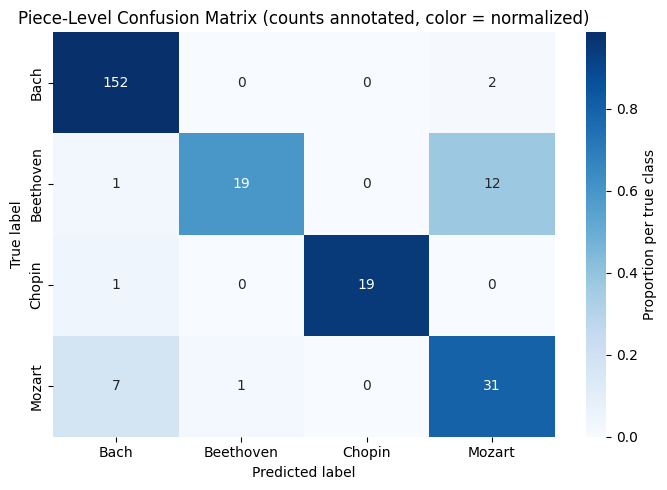

In [63]:
# ==== Piece-level evaluation + pretty confusion matrix ====
import numpy as np
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def piece_level_predict(model, path, vote="prob"):  # vote: "prob" or "majority"
    """Predict a single piece by aggregating window predictions."""
    roll = midi_to_roll(path)
    if roll is None:
        return None
    roll = cap_sustain(roll, max_secs=4.0, fs=FS)
    roll = crop_roll(roll)

    probs_sum = None
    votes = []

    for ch in window_roll(roll, win=WIN, hop=HOP):
        # ensure exact window length (in case of short last chunk or aug mismatch)
        if ch.shape[1] < WIN:
            pad = np.zeros((PITCHES, WIN - ch.shape[1]), dtype=ch.dtype)
            ch = np.concatenate([ch, pad], axis=1)
        elif ch.shape[1] > WIN:
            ch = ch[:, :WIN]

        x = to_input(ch)[None, ...]     # (1, H, W, 1)
        p = model.predict(x, verbose=0)[0]   # probs over classes
        votes.append(int(np.argmax(p)))
        probs_sum = p if probs_sum is None else (probs_sum + p)

    if len(votes) == 0:
        return None

    if vote == "majority":
        return Counter(votes).most_common(1)[0][0]
    else:  # "prob" = probability-weighted voting (recommended)
        return int(np.argmax(probs_sum))

def evaluate_piece_level(model, pairs, vote="prob"):
    """Return y_true, y_pred arrays for the given (path,label) list."""
    y_true, y_pred = [], []
    for path, y in pairs:
        pred = piece_level_predict(model, path, vote=vote)
        if pred is None:  # skip unreadable/bad files
            continue
        y_true.append(y)
        y_pred.append(pred)
    return np.array(y_true), np.array(y_pred)

# ---- run piece-level eval on your test split ----
y_true_piece, y_pred_piece = evaluate_piece_level(model, test, vote="prob")

print("Piece-level report (weighted voting):")
print(classification_report(y_true_piece, y_pred_piece, target_names=CLASSES))

# ---- pretty confusion matrix (counts + normalized color) ----
cm = confusion_matrix(y_true_piece, y_pred_piece, labels=range(len(CLASSES)))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(cm_norm, annot=cm, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES,
            cbar_kws={'label': 'Proportion per true class'})
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Piece-Level Confusion Matrix (counts annotated, color = normalized)")
plt.tight_layout()
plt.show()


### **"piece-level" means**
Instead of treating each 10s clip independently, you aggregate predictions for all clips of the same piece.

Usually, this is done by majority vote or weighted vote (we are using weighted voting).

The final prediction is one label per piece, which better reflects real-world classification — because the end goal is to correctly identify the entire work, not just a fragment.

### **Classification report breakdown**
Metric	Meaning in this context
Precision	Out of all pieces predicted for a composer, how many were correct.
Recall	Out of all pieces belonging to a composer, how many were correctly identified.
F1-score	Balance between precision and recall.
Support	Number of full pieces in the test set for that composer.

### **Observations per composer:**

**Bach**
Recall 0.99 → Nearly every Bach piece is identified correctly.

Precision 0.94 → A few pieces misclassified as Bach from other composers (likely Mozart).

**Beethoven**
Recall 0.59 → Beethoven struggles here; 41% of Beethoven pieces are misclassified (mostly as Mozart).

Precision is high (0.95) → If the model says "Beethoven", it’s usually right — but it says "Beethoven" too rarely.

**Chopin**
Perfect precision (1.00) and strong recall (0.95) → The model identifies Chopin almost flawlessly.

Likely because of his distinct Romantic piano writing style.

**Mozart**
Recall 0.79 → Good but not perfect; some Mozart pieces misclassified as Bach or Beethoven.

Precision 0.69 → Many non-Mozart pieces (especially Beethoven) get predicted as Mozart.

### **Confusion matrix interpretation**

Bach → Mozart confusion is minimal (only 2 pieces).

Beethoven → Mozart confusion is the major problem: 12 pieces misclassified.

Mozart → Bach confusion also appears (7 pieces).

Chopin is nearly isolated — minimal cross-confusion.

Piece-level voting means systematic bias can dominate:
If the majority of Beethoven’s clips lean toward Mozart, the whole piece gets labeled as Mozart.

Their musical styles overlap heavily (Classical era harmony, orchestration, tempo structures).



## 4.6 Recommendations for improvement
* Add temporal sequence modeling

* Use CNN+BiLSTM so the model learns long-term dependencies.

* Increase context window

* Try 15s or 20s clips before voting; more context per decision.

* Composer-specific data augmentation

* Augment Beethoven data more to help the model find distinct features vs. Mozart.

* Hybrid features

* Add harmonic/chord progressions as additional channels to CNN input.
